<font size=25>Ti Tree AEM Extrapolation via Machine Learning</font>

This notebook utilises the same data setup and data as the paleovalley outline predictor.

It uses gravity, magnetics, radiometrics, elevation, slope, aspect, a landsat geomedian and XY as features, with AEM resistivity data from one of Neils' 30 layer model inversions to try and interpolate and extrapolate each layer of AEM across the whole study area. The thought (likely incorrect in retrospect) was that the top layer would be most highly correlated to the surface, for which there was lots of data, so the top layer could be well interpolated. The results of this interpolation would then be a feature for the interpolation of the second layers, and so on.

It then uses the picked depths to paleovalley, along with the interpolated values for all 30 layers, and the original features to attempt to map the base of the paleo valley across the Ti Tree study area.

This doesnt look like its going to work, the AEM is too sparse and the upper layers, being unsaturated often don't give a good AEM response, thus don't add to the quality of the features available for the deeper interpolation.

One final thing to try could be doing log resisitivity, rather than absolute...


# Imports

In [179]:
import xarray as xr
import geopandas as gpd
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from shapely.geometry import Point

from IPython.display import clear_output

import rasterio
from rasterio.plot import show
from rasterio import warp
import gdal
import affine
import pyproj
from osgeo import gdal

from sklearn import preprocessing
from sklearn.svm import SVR

import math
import pickle
import datetime

# Load the Required Data

## Load the Study Area bounds
Save the bounding box so that other national data sources can be cropped to fit

studyarea_crs {'proj': 'longlat', 'ellps': 'GRS80', 'no_defs': True}
132.9598698750001 134.2741126830001 -23.054892064999933 -21.695553736999955


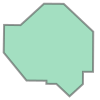

In [3]:
# load just the polygon for the Ti Tree Study Area
tt_studyarea = gpd.read_file('../GAData/EFTF_extents_March_2017.shp').loc[5,'geometry']
studyarea_crs = gpd.read_file('../GAData/EFTF_extents_March_2017.shp').crs
print('studyarea_crs', studyarea_crs)
x, y = tt_studyarea.exterior.xy
# define the study area for cropping other datasets to
xmin, xmax = np.array(x).min(), np.array(x).max()
ymin, ymax = np.array(y).min(), np.array(y).max()
print(xmin, xmax, ymin, ymax)
tt_studyarea

## Open the National Geophysical Datasets, and crop to fit study area

In [4]:
def transformToAffine(transformstring):
    '''
    A quick helper function for datasets that only have a GDAL style GeoTransform, no Affine matrix.
    '''
    abcdef = transformstring.split()
    abcdef = [float(i) for i in abcdef]
    return affine.Affine.from_gdal(*abcdef)

In [5]:
# NCI file locations discovered from https://geonetwork.nci.org.au/geonetwork/srv/eng/catalog.search#/search
# the data layer name has been manually harvested for each
ngd_locs = {'mag': ['mag_tmi_rtp_anomaly', r'/g/data1/rr2/national_geophysical_compilations/magmap_v6_2015_VRTP/magmap_v6_2015_VRTP.nc'],
             'th': ['rad_th_equiv_conc', r'/g/data1/rr2/national_geophysical_compilations/radmap_v3_2015_filtered_ppmth/radmap_v3_2015_filtered_ppmth.nc'],
             'u': ['rad_u_equiv_conc', r'/g/data1/rr2/national_geophysical_compilations/radmap_v3_2015_filtered_ppmu/radmap_v3_2015_filtered_ppmu.nc'],
             'k': ['rad_k_conc', r'/g/data1/rr2/national_geophysical_compilations/radmap_v3_2015_filtered_pctk/radmap_v3_2015_filtered_pctk.nc'],
             'grav': ['grav_complete_boug_anomaly', r'/g/data1/rr2/national_geophysical_compilations/onshore_geodetic_Complete_Bouguer_2016/onshore_geodetic_Complete_Bouguer_2016.nc']}

data = {}
for key, [name, file] in ngd_locs.items():
    # open the file
    ds = xr.open_dataset(file)
    # combine the attributes from the crs dataarray with the overall attribs, and save for later
    attrs = {**ds.attrs, **ds.crs.attrs}
    # find the lat and lon of the top left corner of the study area bounding box
    tl = ds[name].sel(lon=xmin, method = 'nearest').sel(lat=ymax, method = 'nearest')
    # Find the lat and lon of the bottom right corner of the study area bounding box
    br = ds[name].sel(lon=xmax, method = 'nearest').sel(lat=ymin, method = 'nearest')
    # select the relevant data and save over the nationwide datavalues
    ds = ds[name].loc[tl.lat.values:br.lat.values,tl.lon.values:br.lon.values]
    # add the attribs to ds (which is really a DA at this point)
    ds.attrs = attrs
    # define the affine attribute based on the GeoTransform (affine are used throughout)
    ds.attrs['affine'] = transformToAffine(ds.attrs['GeoTransform'])
    # rename long and lat to x and y so these line up with all the other datasets that are UTM based
    ds = ds.rename({'lon':'x','lat':'y'})
    # save to a dict for future use
    data[key] = ds
    print(key, ds.shape)

mag (1633, 1578)
th (1360, 1315)
u (1360, 1315)
k (1360, 1315)
grav (164, 158)


## Load Raster Data

### Functions to Aid in Loading Rasters

In [6]:
def buildRasterAttributes(raster):
    '''
    A function that extracts the key aspects of a rasters profile and saves them to a dict
    '''
    attribs = {}
    attribs['count'] = raster.count
    attribs['width'] = raster.width
    attribs['height'] = raster.height
    attribs['bounds'] = raster.bounds
    attribs['transform'] = raster.transform
    attribs['affine'] = raster.affine
    attribs['crs'] = raster.crs
    attribs['nodata'] = raster.nodata
    return attribs

In [7]:
def buildAxesFromAttributes(attribs):
    '''
    Build numpy arrays for '''
    # build a numpy array of a range of the coordinates for a given set of attributes
    # set to np.float32 to save space
    xaxis = (np.arange(attribs['affine'][2],
                      attribs['affine'][2] + (attribs['affine'][0] * attribs['width']),
                      attribs['affine'][0])).astype(np.float32)
    yaxis = (np.arange(attribs['affine'][5],
                      attribs['affine'][5] + (attribs['affine'][4] * attribs['height']),
                      attribs['affine'][4])).astype(np.float32)
    return xaxis, yaxis

In [8]:
def rasterToXarray(fullpath, bandnames = None):
    '''
    A shortcut to building an Xarray from a single or multiband raster.
    Takes the full path of the raster as the primary parameter.
    If the raster is multi band, it takes a list of band names as the second parameter.
    If the raster is a single band, the function returns a dataarray.
    In the case of a multiband raster, the function returns a dataset
    ''' 
        
    with rasterio.open(fullpath, 'r') as src:
        # save the profile
        profile = buildRasterAttributes(src)
        # read the data, and set to np.float32 to save space    
        rasterdata = src.read().astype(np.float32)
        # boolean mask to change all "no data" values to np.nan
        rasterdata[rasterdata == profile['nodata']] = np.nan    
        # update the attributes to the new nodata value
        profile['nodata'] = np.nan    

        # build the coordinate lists
        x, y = buildAxesFromAttributes(profile)

        xarrays = []
        for i in range(rasterdata.shape[0]):
            xarrays.append(xr.DataArray(rasterdata[i], [('y', y), ('x', x)]))
            # set the attributes of the dataarray to the attributs of the parent raster
            xarrays[i].attrs = profile
        if len(xarrays) == 1:
            return xarrays[0]
        else:
            if bandnames == None:
                print('Please provide some bandnames for the multiband raster you are trying to open')
            elif len(bandnames) != len(xarrays):
                print('You have provided', len(bandnames), 'band names for the raster which has', len(xarrays), 'bands. Please rectify.')
                return
            else:
                ds = {bandnames[i] : xarrays[i] for i in range(rasterdata.shape[0])}
                ds = xr.Dataset(ds)
                ds.attrs = profile
                return ds

### Load Elevation Data

In [9]:
# define where the DEM data lives
dem_dir = '/g/data1a/zk34/mb4539/ssc/GAData/'
# define the DEM files to be opened
dem_files = {'elevation':'tt_dem_500m.tif', 'aspect': 'tt_aspect_500m.tif', 'slope': 'tt_slope_500m.tif'}
dem_paths = {name : dem_dir + file for name, file in dem_files.items()}

# dem_paths
for name, file in dem_paths.items():
    data[name] = rasterToXarray(file)
data.keys()

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:12: RasterioDeprecationWarning: 'src.affine' is deprecated.  Please switch to 'src.transform'. See https://github.com/mapbox/rasterio/issues/86 for details.
  if sys.path[0] == '':
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:12: RasterioDeprecationWarning: 'src.affine' is deprecated.  Please switch to 'src.transform'. See https://github.com/mapbox/rasterio/issues/86 for details.
  if sys.path[0] == '':
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:12: RasterioDeprecationWarning: 'src.affine' is deprecated.  Please switch to 'src.transform'. See https://github.com/mapbox/rasterio/issues/86 for details.
  if sys.path[0] == '':


dict_keys(['mag', 'th', 'u', 'k', 'grav', 'elevation', 'aspect', 'slope'])

### Load DEA Geomedian

In [10]:
data['landsat'] = rasterToXarray('/g/data1a/zk34/mb4539/ssc/GAData/2017geomed.tif', ['blue','green','red','nir','swir1','swir2'])
print(data.keys())
data['landsat']

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:12: RasterioDeprecationWarning: 'src.affine' is deprecated.  Please switch to 'src.transform'. See https://github.com/mapbox/rasterio/issues/86 for details.
  if sys.path[0] == '':


dict_keys(['mag', 'th', 'u', 'k', 'grav', 'elevation', 'aspect', 'slope', 'landsat'])


<xarray.Dataset>
Dimensions:  (x: 5444, y: 6142)
Coordinates:
  * y        (y) float32 -2333350.0 -2333375.0 -2333400.0 -2333425.0 ...
  * x        (x) float32 97425.0 97450.0 97475.0 97500.0 97525.0 97550.0 ...
Data variables:
    blue     (y, x) float32 nan nan nan nan nan nan nan nan nan nan nan nan ...
    green    (y, x) float32 nan nan nan nan nan nan nan nan nan nan nan nan ...
    red      (y, x) float32 nan nan nan nan nan nan nan nan nan nan nan nan ...
    nir      (y, x) float32 nan nan nan nan nan nan nan nan nan nan nan nan ...
    swir1    (y, x) float32 nan nan nan nan nan nan nan nan nan nan nan nan ...
    swir2    (y, x) float32 nan nan nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    count:      6
    width:      5444
    height:     6142
    bounds:     BoundingBox(left=97425.0, bottom=-2486900.0, right=233525.0, ...
    transform:  | 25.00, 0.00, 97425.00|\n| 0.00,-25.00,-2333350.00|\n| 0.00,...
    affine:     | 25.00, 0.00, 97425.00|\n| 0.00,-25.00,-2

## Load AEM Data

In [11]:
data['aem'] = pd.read_csv('../GAData/TT_AEM_with_allPVDepth.csv')
# # make a geometry column with shapely points
data['aem']['geometry'] = data['aem'].apply(lambda x: Point((float(x.easting), float(x.northing))), axis=1)
# # change to a geodataframe
data['aem'] = gpd.GeoDataFrame(data['aem'], crs = {'init': 'espg:28353'}, geometry = 'geometry')
if 'espg' in data['aem'].crs['init']:
    data['aem'].crs['init'] = data['aem'].crs['init'].replace('espg','epsg')

# # newx, newy = pyproj.transform(pyproj.Proj(init='epsg:28353'),
# #                               coords_proj,
# #                               data['aem']['easting'].values,
# #                               data['aem']['easting'].values)
# # data['aem']['newx'] = newx
# # data['aem']['newy'] = newy
print(data['aem'].crs)
data['aem'][data['aem']['depth_to_basement'].notnull()]

{'init': 'epsg:28353'}
I am densified (60 elements)
I am densified (60 elements)


,Unnamed: 0,sequence,line,easting,northing,elevation,DataResidual,Residual2,Residual3,TotalResidual,...,24_depth_top,25_depth_top,26_depth_top,27_depth_top,28_depth_top,29_depth_top,30_depth_top,dist_from_point,depth_to_basement,geometry
11116,165850,9868,118251,320023.2,7557958.0,561.71,5.248,0.0,0.862,0.623,...,204.67,237.55,275.7,319.96,371.31,430.88,500.0,44962.601912,530.000000,POINT (320023.2 7557958)
11117,165851,9869,118251,320012.8,7557944.0,561.56,5.669,0.0,1.049,0.743,...,204.67,237.55,275.7,319.96,371.31,430.88,500.0,44980.042042,530.000000,POINT (320012.8 7557944)
11118,165852,9870,118251,320002.4,7557930.0,561.39,10.632,0.0,0.115,0.397,...,204.67,237.55,275.7,319.96,371.31,430.88,500.0,44997.482171,530.000000,POINT (320002.4 7557930)
11119,165853,9871,118251,319991.9,7557916.0,561.24,6.091,0.0,1.121,0.803,...,204.67,237.55,275.7,319.96,371.31,430.88,500.0,45014.982133,530.000000,POINT (319991.9 7557916)
11120,165854,9872,118251,319981.5,7557902.0,561.14,7.159,0.0,0.242,0.362,...,204.67,237.55,275.7,319.96,371.31,430.88,500.0,45032.422262,530.000000,POINT (319981.5 7557902)
11121,165855,9873,118251,319971.4,7557888.0,561.03,5.840,0.0,0.819,0.618,...,204.67,237.55,275.7,319.96,371.31,430.88,500.0,45049.682896,530.000000,POINT (319971.4 7557888)
11122,165856,9874,118251,319961.7,7557875.0,560.89,6.057,0.0,0.667,0.534,...,204.67,237.55,275.7,319.96,371.31,430.88,500.0,45065.902945,530.000000,POINT (319961.7 7557875)
11123,165857,9875,118251,319952.2,7557861.0,560.68,10.492,0.0,0.119,0.404,...,204.67,237.55,275.7,319.96,371.31,430.88,500.0,45082.804597,530.000000,POINT (319952.2 7557861)
11124,165858,9876,118251,319942.7,7557848.0,560.42,9.818,0.0,0.120,0.394,...,204.67,237.55,275.7,319.96,371.31,430.88,500.0,45098.904985,530.000000,POINT (319942.7 7557848)
11125,165859,9877,118251,319932.7,7557834.0,560.17,6.058,0.0,0.478,0.442,...,204.67,237.55,275.7,319.96,371.31,430.88,500.0,45116.105797,530.000000,POINT (319932.7 7557834)


# Coordinate Systems Definitions

In [12]:
studyarea_epsg = '4326'                   # WGS84 Geographic LatLong
data_epsgcodes = {'grav':'4283',          # GDA94 Geographic LatLong
                    'mag':'4283',
                    'k':'4283',
                    'u':'4283',
                    'th':'4283',
                    'landsat':'3577',     # GDA94 Albers zone 53 South projected coords (landsat)
                    'elevation':'28353',  # WGS zone 53 south projected coords 
                    'slope':'28353',
                    'aspect':'28353',
                     'aem': '28353'}

for dtype, epsg in data_epsgcodes.items():
    try: 
        data[dtype].attrs['epsg'] = data_epsgcodes[dtype]
        print(dtype, 'worked')
    except:
        print(dtype, "failed")
        continue


grav worked
mag worked
k worked
u worked
th worked
landsat worked
elevation worked
slope worked
aspect worked
aem failed


# Setup the Interpolation Grid

In [143]:
# create the grid to be interpolated

# find the top left corner of the study area in AEA, same for bottom right.
trainingdata_crs = pyproj.Proj(init='epsg:3577')
studyarea_proj = pyproj.Proj(init= 'epsg:' + studyarea_epsg)
# based on shapefile bounding box, from WGS85 to GDA94 AEA
tlx, tly = pyproj.transform(studyarea_proj,trainingdata_crs, xmin, ymax)
brx, bry = pyproj.transform(studyarea_proj,trainingdata_crs, xmax, ymin)

# # subset for speed
# tlx, brx,tly,  bry = 160000, 165000, -2395000, -2400000

# define cell size appropriate to desired CRS (in this case, metres because using AEA)
cellsize = 500
# make the ranges for the study area
xrange = range(int(tlx), int(brx) + cellsize, cellsize)
yrange = range(int(bry), int(tly) + cellsize, cellsize)

# meshgrid, or just make a list
xcol = []
ycol = []
for ycell in yrange:
    for xcell in xrange:
        xcol.append(xcell)
        ycol.append(ycell)

# make a dataframe to store all data in
trainingdata = pd.DataFrame(columns = data.keys())
# set the x and y values as columns
trainingdata['x'] = xcol
trainingdata['y'] = ycol
# save some memory
del xcol, ycol

# drop some column names that aren't needed
trainingdata = trainingdata.drop(labels = ['aem', 'landsat'], axis = 1)
# make some columns names that are needed for landsat bands and resistivity layers
landsatbands = list(data['landsat'].data_vars)
for band in landsatbands:
    trainingdata[band] = np.nan
ress = [str(i) + '_resistivity' for i in range(1, 31)]
for res in ress:
    trainingdata[res] = np.nan
    
# to save memory and deal with object type nan, as opposed to float NaN
trainingdata = trainingdata.astype(np.float32)
print(list(trainingdata.columns))
trainingdata

['mag', 'th', 'u', 'k', 'grav', 'elevation', 'aspect', 'slope', 'x', 'y', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', '1_resistivity', '2_resistivity', '3_resistivity', '4_resistivity', '5_resistivity', '6_resistivity', '7_resistivity', '8_resistivity', '9_resistivity', '10_resistivity', '11_resistivity', '12_resistivity', '13_resistivity', '14_resistivity', '15_resistivity', '16_resistivity', '17_resistivity', '18_resistivity', '19_resistivity', '20_resistivity', '21_resistivity', '22_resistivity', '23_resistivity', '24_resistivity', '25_resistivity', '26_resistivity', '27_resistivity', '28_resistivity', '29_resistivity', '30_resistivity']


,mag,th,u,k,grav,elevation,aspect,slope,x,y,...,21_resistivity,22_resistivity,23_resistivity,24_resistivity,25_resistivity,26_resistivity,27_resistivity,28_resistivity,29_resistivity,30_resistivity
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98567.0,-2486883.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99067.0,-2486883.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99567.0,-2486883.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100067.0,-2486883.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100567.0,-2486883.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101067.0,-2486883.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101567.0,-2486883.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102067.0,-2486883.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102567.0,-2486883.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103067.0,-2486883.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Populate Grid

## Data Gathering Functions

### getAEMValue

In [73]:
def getAEMValue(coords, coords_proj, cellsize, ress):
    # create a projection object for the dataarray being queried
    data_crs = pyproj.Proj(init=data['aem'].crs['init'])
    # convert the incoming query coordinates to the new CRS
    newcrs_x, newcrs_y = pyproj.transform(coords_proj, data_crs, coords[0],coords[1])
    
    # need to deal with cell size not in metres (eg decimal degrees)
    # do this by adding the cell size to the input coordinates
    # run this through the projection transform
    # and calculate the difference betwee this dummy coordinate pair and the ones being queried
    dummy_x, dummy_y = coords[0] + cellsize, coords[1] + cellsize
    newcrs_dummy_x, newcrs_dummy_y = pyproj.transform(coords_proj, data_crs, dummy_x, dummy_y)
    transformed_gridsize = round(abs(newcrs_dummy_x - newcrs_x),3)
    # select the fiducials that are within the pixel area
    fids = data['aem'][(data['aem']['easting'] >= newcrs_x - (transformed_gridsize/2)) &
                (data['aem']['easting'] <= newcrs_x + (transformed_gridsize/2)) &
                (data['aem']['northing'] >= newcrs_y - (transformed_gridsize/2)) &
                (data['aem']['northing'] <= newcrs_y + (transformed_gridsize/2))]
    if len(fids) == 0:  # if there is no AEM in this cell
        return np.nan
    else:
        return fids[ress].mean(axis = 0)

### getDataValue

In [71]:
def getDataValue(datatype, coords, coords_proj, cellsize):
    '''
    This function takes the X and Y of the cell being populated in the training/predicted grid
    along with the datatype it want to populate, the coordinates of the training grid and the
    cell size of the existing grid.
    
    It converts the coordinates to the coordinates of the trainig cell into the crs of the known data.
    It then queries the dataarray, and pulls either just the corresponding cell value or an average of
    several cells dpending on the relative gridcell sizes.
    
    It returns this value back to the caller.
    '''

    # create a projection object for the dataarray being queried
    data_crs = pyproj.Proj(init='epsg:' + data[datatype].attrs['epsg'])
    # convert the incoming query coordinates to the new CRS
    newcrs_x, newcrs_y = pyproj.transform(coords_proj, data_crs, coords[0],coords[1])
    
    # need to deal with cell size not in metres (eg decimal degrees)
    # do this by adding the cell size to the input coordinates
    # run this through the projection transform
    # and calculate the difference betwee this dummy coordinate pair and the ones being queried
    dummy_x, dummy_y = coords[0] + cellsize, coords[1] + cellsize
    newcrs_dummy_x, newcrs_dummy_y = pyproj.transform(coords_proj, data_crs, dummy_x, dummy_y)
    transformed_gridsize = round(abs(newcrs_dummy_x - newcrs_x),3)
#     print(newcrs_x, newcrs_y, transformed_gridsize)
    # if the cell size for the array being created is smaller than that of the data,
    # find the single cell that best aligns with the cell to be populated
    if data[datatype].attrs['affine'][0] >= transformed_gridsize:
        return data[datatype].sel(x = newcrs_x, y = newcrs_y, method = 'nearest').values
    # if the new grid is coarser than the existing one, serach over the range +/- a pixel
    # and return the mean of all the values collected.
    # not good for slope or aspect
    else:
        return np.nanmean(data[datatype].sel(x=slice(newcrs_x-(transformed_gridsize/2),
                                   newcrs_x + (transformed_gridsize/2)),
                                   y = slice(newcrs_y + (transformed_gridsize/2),
                                             newcrs_y - (transformed_gridsize/2))).values)

### Get LandsatValue

In [72]:
def getLandsatValue(band, coords, coords_proj, cellsize):
    '''

    '''

    # create a projection object for the dataarray being queried
    data_crs = pyproj.Proj(init='epsg:' + data['landsat'].attrs['epsg'])
    # convert the incoming query coordinates to the new CRS
    newcrs_x, newcrs_y = pyproj.transform(coords_proj, data_crs, coords[0],coords[1])
    
    # need to deal with cell size not in metres (eg decimal degrees)
    # do this by adding the cell size to the input coordinates
    # run this through the projection transform
    # and calculate the difference betwee this dummy coordinate pair and the ones being queried
    dummy_x, dummy_y = coords[0] + cellsize, coords[1] + cellsize
    newcrs_dummy_x, newcrs_dummy_y = pyproj.transform(coords_proj, data_crs, dummy_x, dummy_y)
    transformed_gridsize = round(abs(newcrs_dummy_x - newcrs_x),3)

    # if the cell size for the array being created is smaller than that of the data,
    # find the single cell that best aligns with the cell to be populated
    if data['landsat'][band].attrs['affine'][0] >= transformed_gridsize:
        return data['landsat'][band].sel(x = newcrs_x, y = newcrs_y, method = 'nearest').values
    # if the new grid is coarser than the existing one, serach over the range +/- a pixel
    # and return the mean of all the values collected.
    # not good for slope or aspect
    else:
        return np.nanmean(data['landsat'][band].sel(x=slice(newcrs_x-(transformed_gridsize/2),
                                   newcrs_x + (transformed_gridsize/2)),
                                   y = slice(newcrs_y + (transformed_gridsize/2),
                                             newcrs_y - (transformed_gridsize/2))).values)

## Populate the Grid

In [144]:
start = datetime.datetime.now()

# only do the easy ones to start
easy_data = [key for key in data.keys() if key not in ['aem','landsat']]
# easy_data = ['k','th','u','mag']


# for each row
for index, row in trainingdata.iterrows():
    # save the coords
    train_coords = trainingdata.loc[index, ['x', 'y']]

#     populate the easy raster based datasets
    for dtype in easy_data:
        trainingdata.loc[index, dtype] = getDataValue(dtype, train_coords, trainingdata_crs, cellsize)
    
#     populate the landsat image data
    for band in landsatbands:
        trainingdata.loc[index, band] = getLandsatValue(band, train_coords, trainingdata_crs, cellsize)
        
    # populate resistivities from AEM
    trainingdata.loc[index, ress] = getAEMValue(train_coords, trainingdata_crs, cellsize, ress)
        
print("Process took:", datetime.datetime.now() - start)
trainingdata

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice


Process took: 0:50:34.062393


,mag,th,u,k,grav,elevation,aspect,slope,x,y,...,21_resistivity,22_resistivity,23_resistivity,24_resistivity,25_resistivity,26_resistivity,27_resistivity,28_resistivity,29_resistivity,30_resistivity
0,NaN,NaN,NaN,NaN,302.114929,NaN,NaN,NaN,98567.0,-2486883.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,303.035400,NaN,NaN,NaN,99067.0,-2486883.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,303.035400,NaN,NaN,NaN,99567.0,-2486883.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,304.281708,NaN,NaN,NaN,100067.0,-2486883.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,304.281708,NaN,NaN,NaN,100567.0,-2486883.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,304.865906,NaN,NaN,NaN,101067.0,-2486883.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,304.787537,NaN,NaN,NaN,101567.0,-2486883.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,304.787537,NaN,NaN,NaN,102067.0,-2486883.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,304.426331,NaN,NaN,NaN,102567.0,-2486883.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,304.426331,NaN,NaN,NaN,103067.0,-2486883.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
# non_geom_cols
# trainingdata = trainingdata[trainingdata.columns[0:-1]].astype(np.float32)
for col in trainingdata.columns:
    print(col, len(trainingdata[trainingdata[col].notnull()]))

mag 81119
th 81069
u 81069
k 81069
grav 82194
elevation 56125
aspect 56125
slope 56125
x 82194
y 82194
blue 56560
green 56560
red 56560
nir 56560
swir1 56560
swir2 56560
1_resistivity 4155
2_resistivity 4155
3_resistivity 4155
4_resistivity 4155
5_resistivity 4155
6_resistivity 4155
7_resistivity 4155
8_resistivity 4155
9_resistivity 4155
10_resistivity 4155
11_resistivity 4155
12_resistivity 4155
13_resistivity 4155
14_resistivity 4155
15_resistivity 4155
16_resistivity 4155
17_resistivity 4155
18_resistivity 4155
19_resistivity 4155
20_resistivity 4155
21_resistivity 4155
22_resistivity 4155
23_resistivity 4155
24_resistivity 4155
25_resistivity 4155
26_resistivity 4155
27_resistivity 4155
28_resistivity 4155
29_resistivity 4155
30_resistivity 4155


## Convert Aspect to Trig Values

In [146]:

# need to use sin and cos of aspect because of the circular nature of it
# (ie 359 and 001 are as close as 90 and 92)
trainingdata['aspect_sin'] = np.sin(trainingdata['aspect'] * (np.pi / 180))
trainingdata['aspect_cos'] = np.cos(trainingdata['aspect'] * (np.pi / 180))
# this column not needed now
trainingdata = trainingdata.drop(['aspect'], axis = 1)
trainingdata

,mag,th,u,k,grav,elevation,slope,x,y,blue,...,23_resistivity,24_resistivity,25_resistivity,26_resistivity,27_resistivity,28_resistivity,29_resistivity,30_resistivity,aspect_sin,aspect_cos
0,NaN,NaN,NaN,NaN,302.114929,NaN,NaN,98567.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,303.035400,NaN,NaN,99067.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,303.035400,NaN,NaN,99567.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,304.281708,NaN,NaN,100067.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,304.281708,NaN,NaN,100567.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,304.865906,NaN,NaN,101067.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,304.787537,NaN,NaN,101567.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,304.787537,NaN,NaN,102067.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,304.426331,NaN,NaN,102567.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,304.426331,NaN,NaN,103067.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Interpolate AEM Values

## Interpolate

In [159]:
# build a list of columns/feautres to use for the classification process
train_features = [col for col in trainingdata.columns if col not in ress]
combo_ress = [res + '_combo' for res in ress]
# print(train_features)

for i, res in enumerate(ress):
    # i = 2
    # res = ress[i]
    # subset the data to non-null rows
    train_ss = trainingdata[trainingdata[res].notnull()].dropna(axis = 0, how = 'any', subset = train_features)
    train_x = train_ss[train_features].values
    train_y = train_ss[res].values

    # scale, normalize, save scaler for f
    scaler = preprocessing.StandardScaler().fit(train_x)
    train_x = scaler.transform(train_x)
    train_x = preprocessing.normalize(train_x)

    clf = SVR()
    clf.fit(train_x,train_y)

    # train the classifier
    predict_ss = trainingdata[trainingdata[res].isnull()].dropna(axis = 0, how = 'any', subset = train_features)[train_features]
    predict_ss_vals = predict_ss.values

    # # scale and normalize the data so it resembles the training data.
    predict_ss_vals = scaler.transform(predict_ss_vals)
    predict_ss_vals = preprocessing.normalize(predict_ss_vals)

    # # results of predict() are a 1 dimensional numpy array of the same length as the input data
    # # assign these results to a new column in the dataframe
    predict_ss[res] = clf.predict(predict_ss_vals)

    # # combine data + pred into a single feature for layer above, insert as new column into trainingdata
    allres = pd.concat([train_ss[[res]],predict_ss[[res]]], axis = 0).rename({res:combo_ress[i]}, axis = 1)
    trainingdata = pd.merge(trainingdata, allres, how='left',left_index = True, right_index = True)
    # # add new column name onto list of valid training features
    train_features += [combo_ress[i]]
    print(res, 'done')
    # print(train_features)

print(trainingdata.columns)
trainingdata

1_resistivity done
2_resistivity done
3_resistivity done
4_resistivity done
5_resistivity done
6_resistivity done
7_resistivity done
8_resistivity done
9_resistivity done
10_resistivity done
11_resistivity done
12_resistivity done
13_resistivity done
14_resistivity done
15_resistivity done
16_resistivity done
17_resistivity done
18_resistivity done
19_resistivity done
20_resistivity done
21_resistivity done
22_resistivity done
23_resistivity done
24_resistivity done
25_resistivity done
26_resistivity done
27_resistivity done
28_resistivity done
29_resistivity done
30_resistivity done
Index(['mag', 'th', 'u', 'k', 'grav', 'elevation', 'slope', 'x', 'y', 'blue',
       'green', 'red', 'nir', 'swir1', 'swir2', '1_resistivity',
       '2_resistivity', '3_resistivity', '4_resistivity', '5_resistivity',
       '6_resistivity', '7_resistivity', '8_resistivity', '9_resistivity',
       '10_resistivity', '11_resistivity', '12_resistivity', '13_resistivity',
       '14_resistivity', '15_resistiv

,mag,th,u,k,grav,elevation,slope,x,y,blue,...,21_resistivity_combo,22_resistivity_combo,23_resistivity_combo,24_resistivity_combo,25_resistivity_combo,26_resistivity_combo,27_resistivity_combo,28_resistivity_combo,29_resistivity_combo,30_resistivity_combo
0,NaN,NaN,NaN,NaN,302.114929,NaN,NaN,98567.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,303.035400,NaN,NaN,99067.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,303.035400,NaN,NaN,99567.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,304.281708,NaN,NaN,100067.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,304.281708,NaN,NaN,100567.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,304.865906,NaN,NaN,101067.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,304.787537,NaN,NaN,101567.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,304.787537,NaN,NaN,102067.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,304.426331,NaN,NaN,102567.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,304.426331,NaN,NaN,103067.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## View the Results

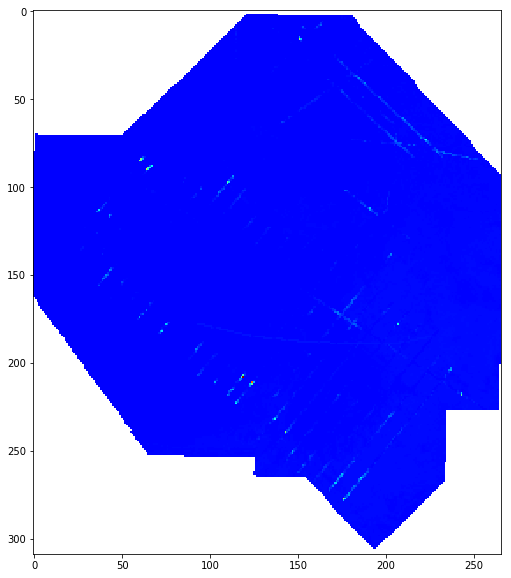

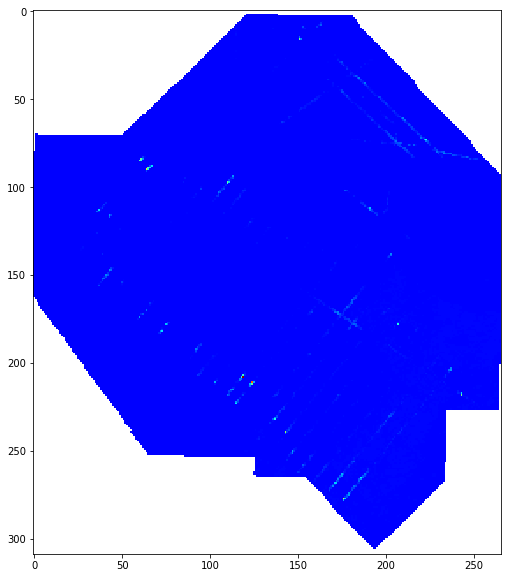

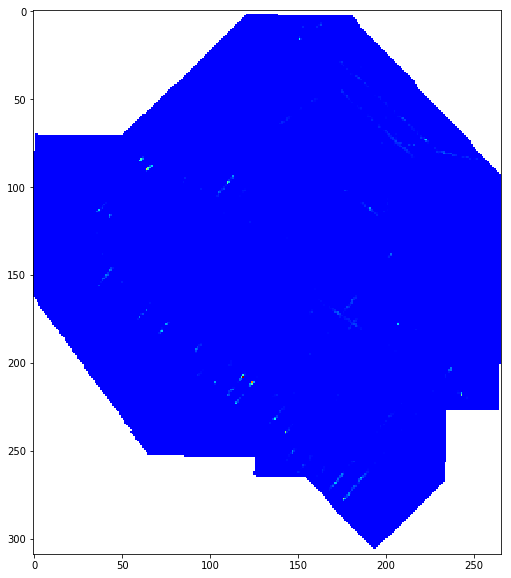

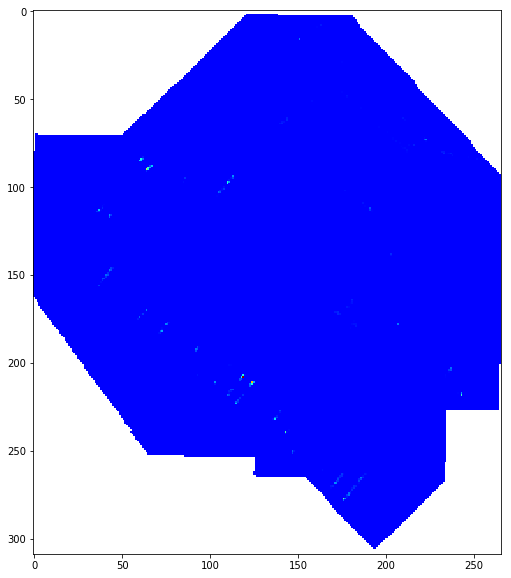

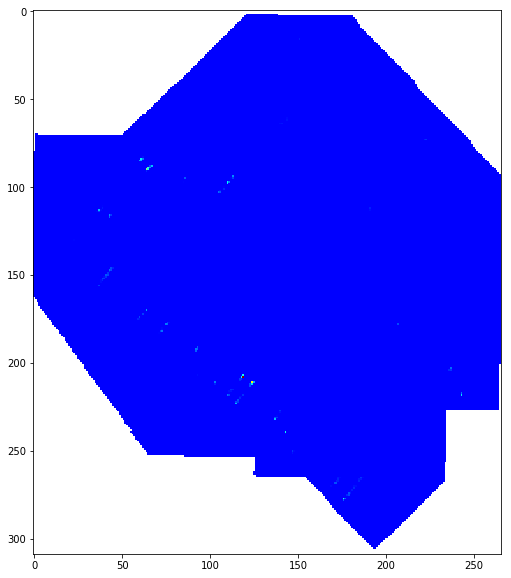

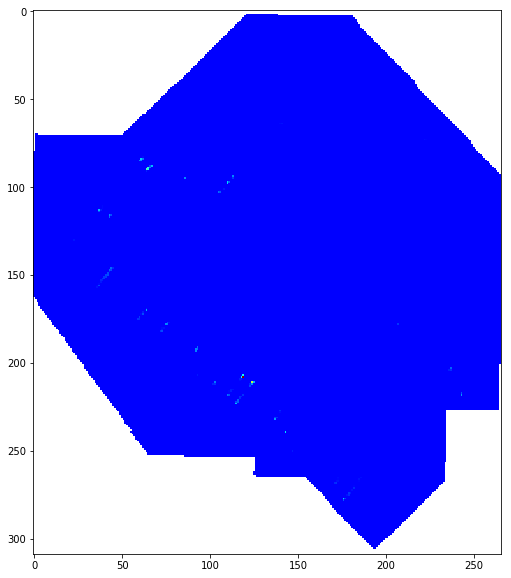

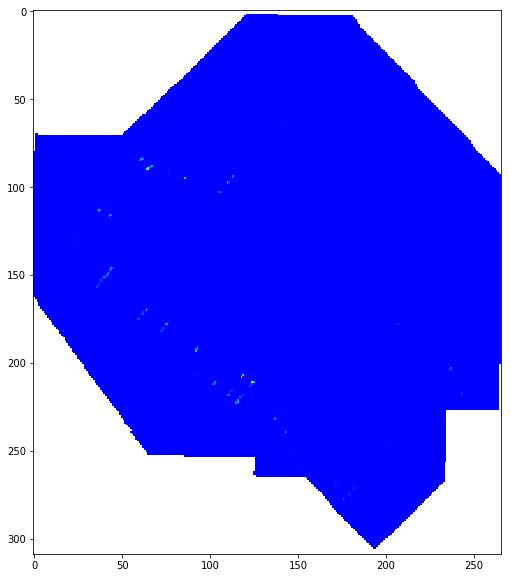

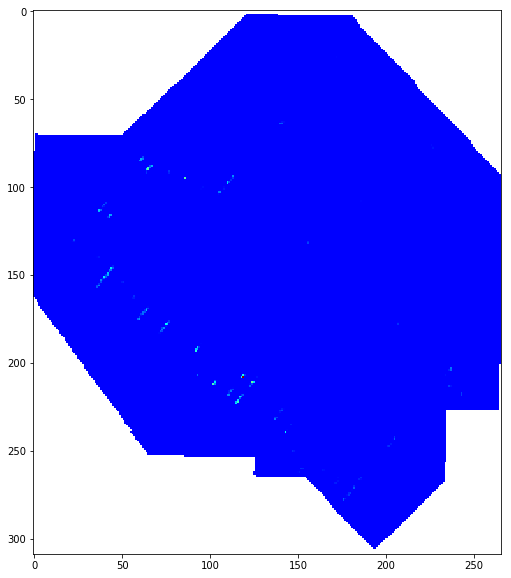

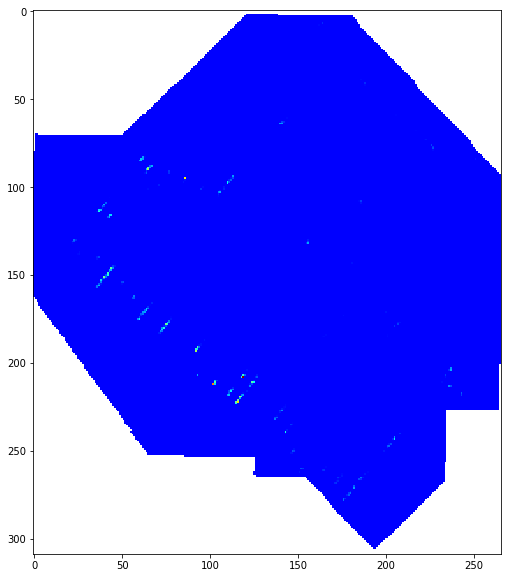

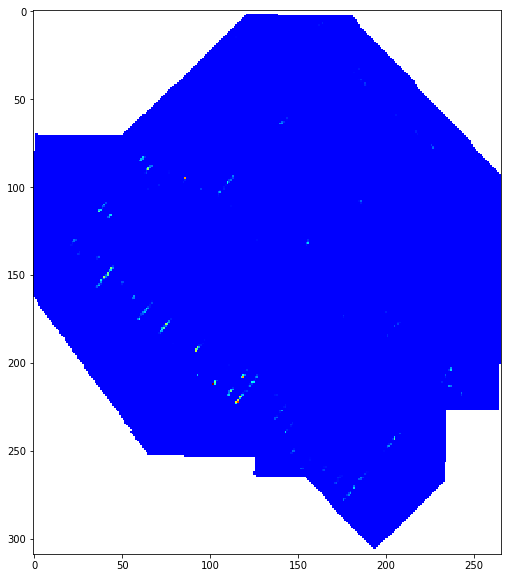

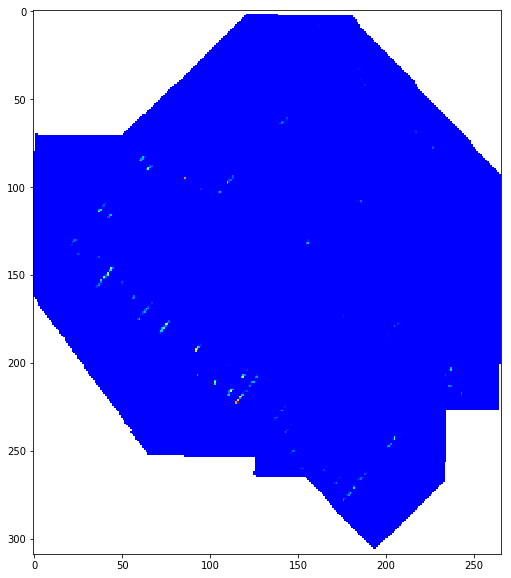

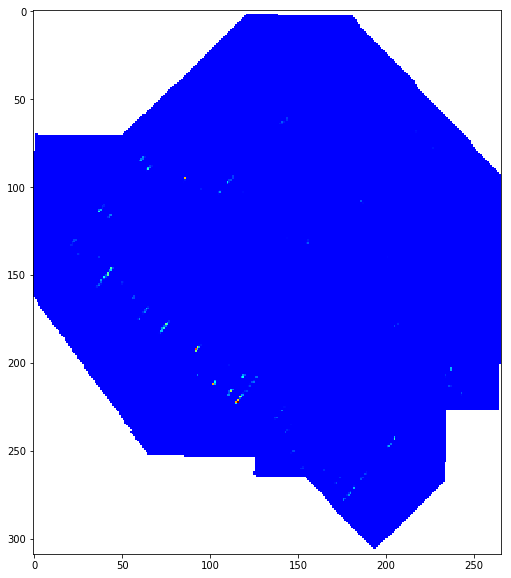

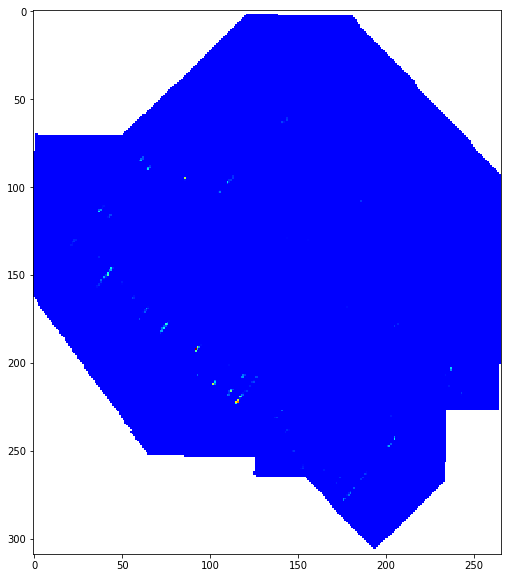

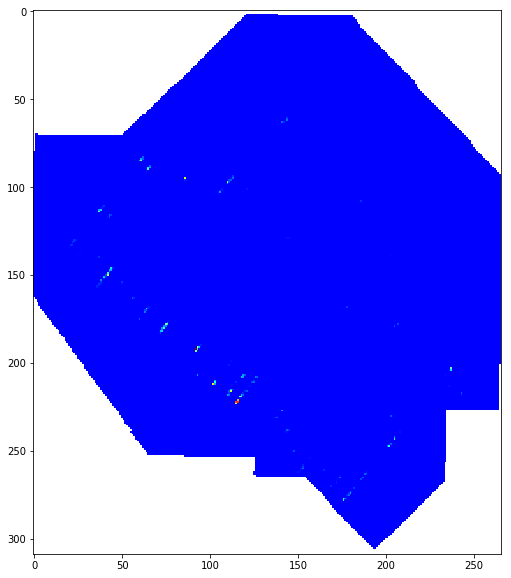

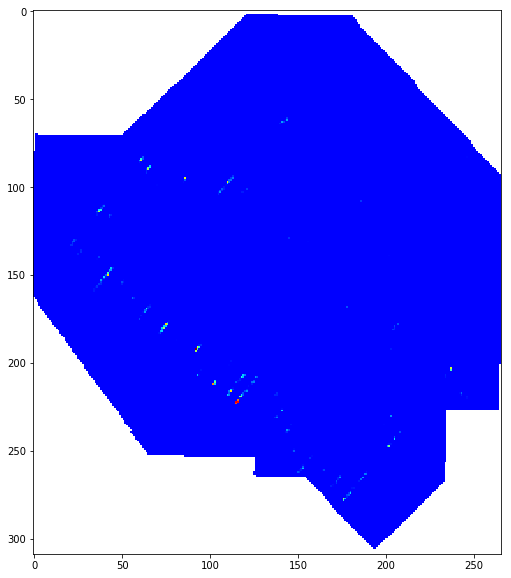

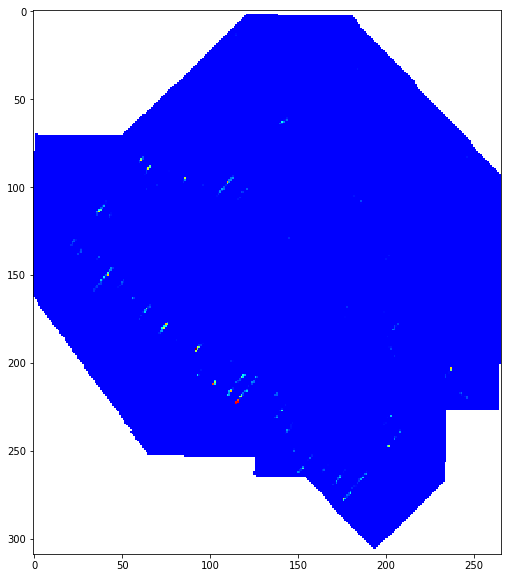

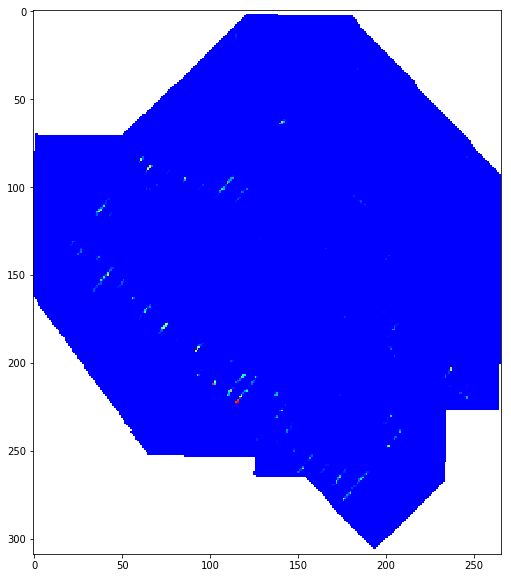

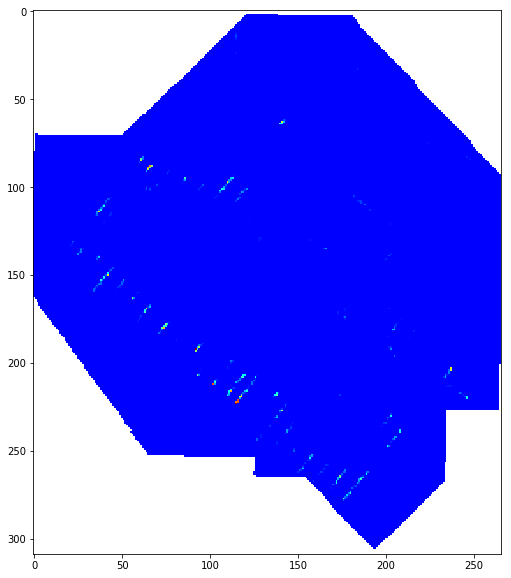

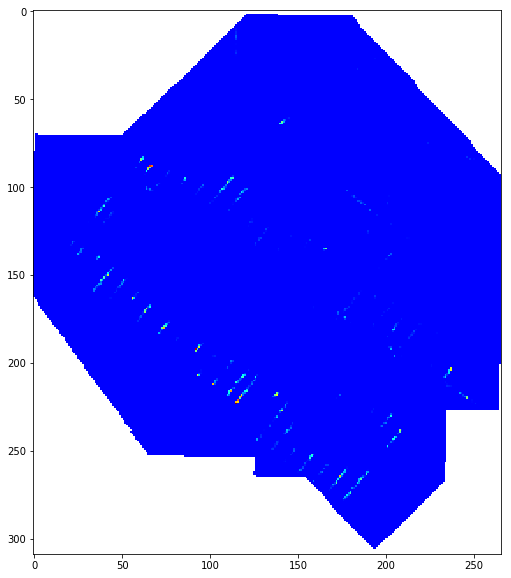

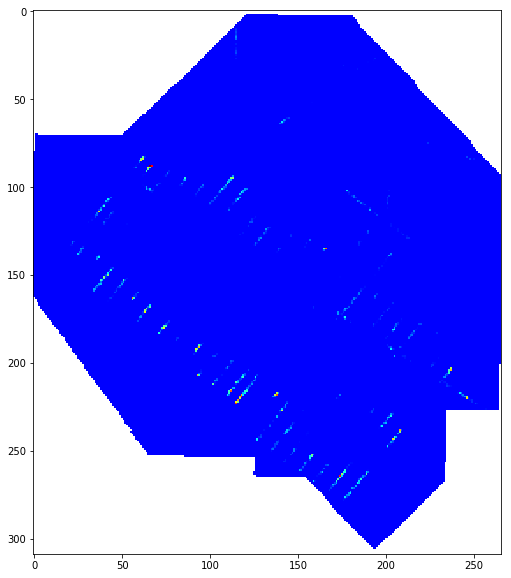

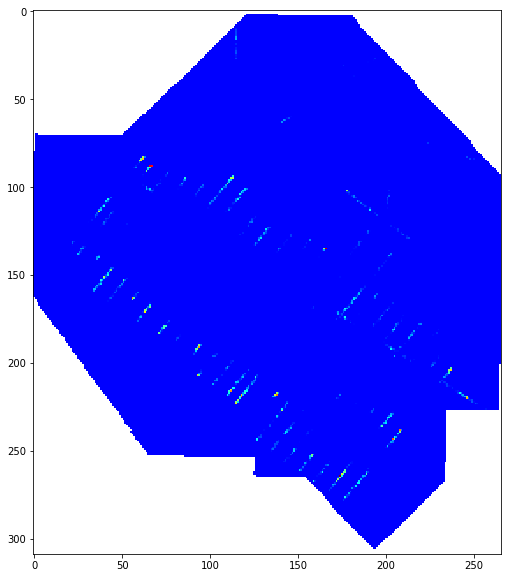

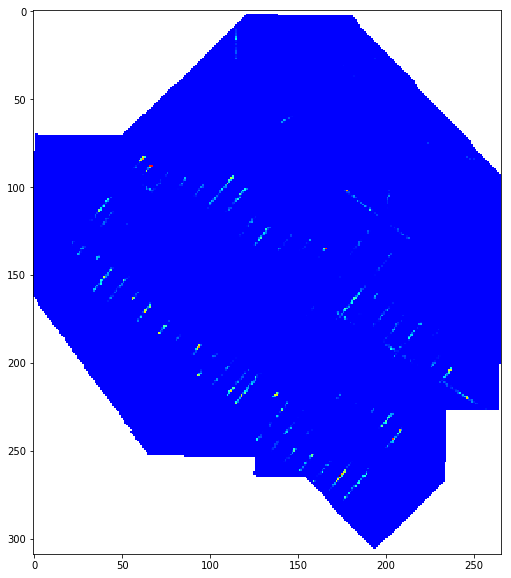

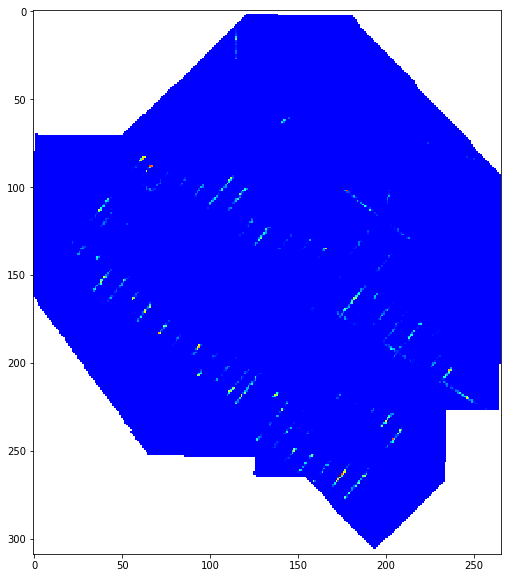

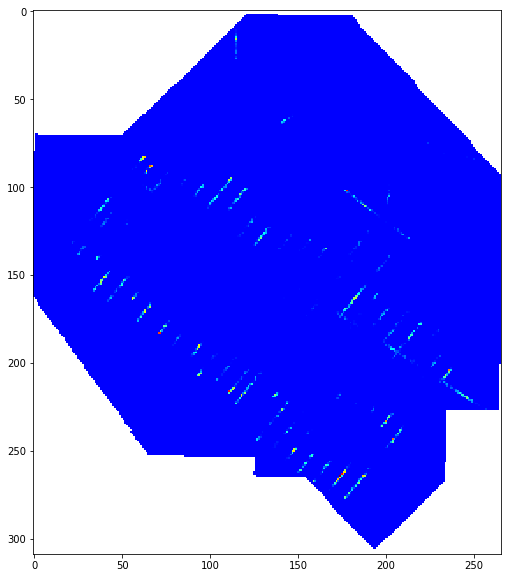

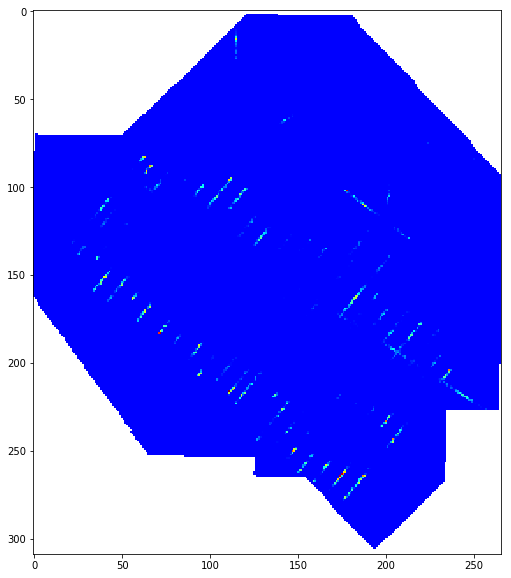

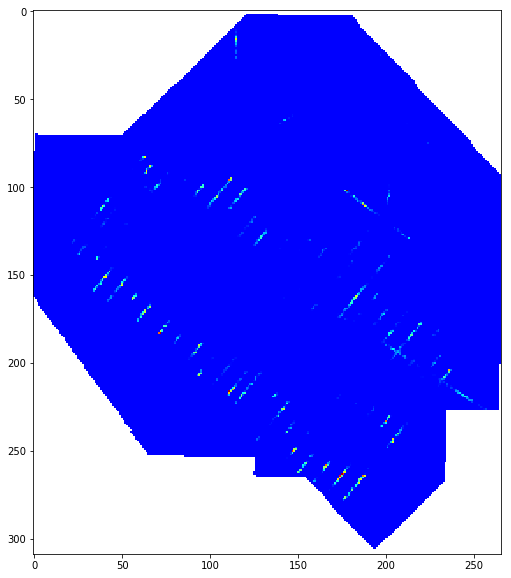

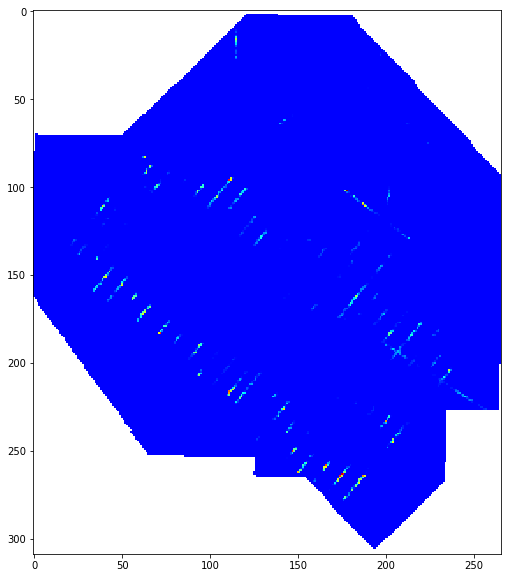

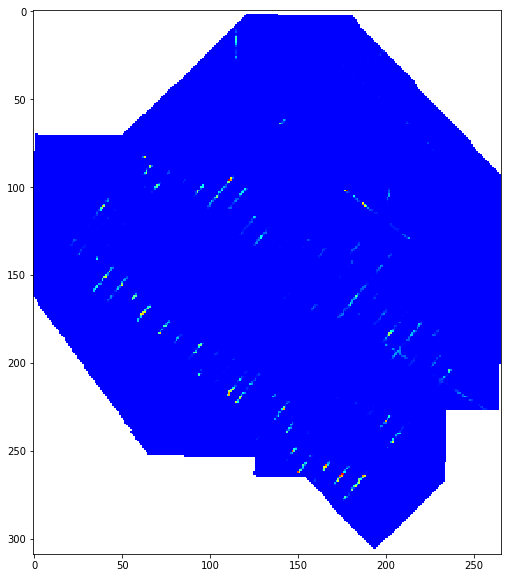

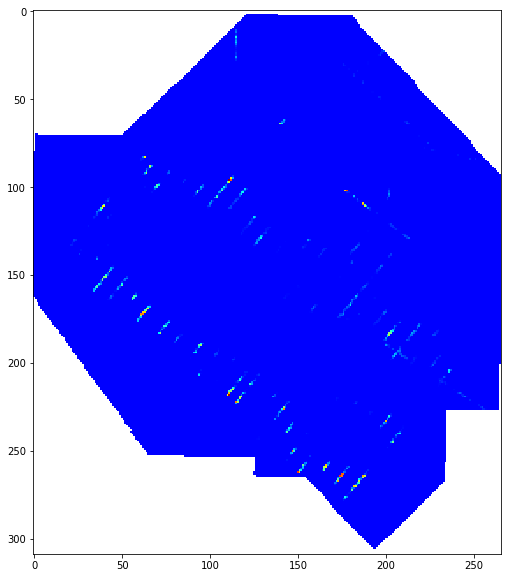

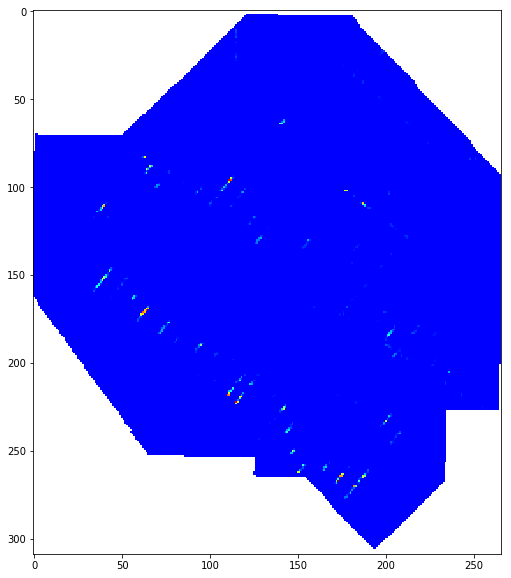

In [204]:
import matplotlib.colors as mcolors
import matplotlib.colors as colors

# pinched from Neil
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

c = mcolors.ColorConverter().to_rgb
# make a colour map that is typical of AEM plots
rvb = make_colormap(
    [c('b'), c('blue'), 0.05, c('blue'), c('cyan'), 0.33, c('cyan'), c('yellow'), 0.66, c('yellow'),  c('red'), 0.95, c('red'), c('darkred')])


for combo_res in combo_ress:
    plt.figure(figsize=[10,10])
    vals = trainingdata[combo_res].values.reshape(len(yrange), len(xrange))
    imshow(np.flipud(vals), cmap = rvb)
    plt.show()

# Predict PV Depths

## Populate PV Pick Depths

In [176]:
def getPVDepth(coords, coords_proj, cellsize):
    # create a projection object for the dataarray being queried
    data_crs = pyproj.Proj(init=data['aem'].crs['init'])
    # convert the incoming query coordinates to the new CRS
    newcrs_x, newcrs_y = pyproj.transform(coords_proj, data_crs, coords[0],coords[1])
    
    # need to deal with cell size not in metres (eg decimal degrees)
    # do this by adding the cell size to the input coordinates
    # run this through the projection transform
    # and calculate the difference betwee this dummy coordinate pair and the ones being queried
    dummy_x, dummy_y = coords[0] + cellsize, coords[1] + cellsize
    newcrs_dummy_x, newcrs_dummy_y = pyproj.transform(coords_proj, data_crs, dummy_x, dummy_y)
    transformed_gridsize = round(abs(newcrs_dummy_x - newcrs_x),3)
    # select the fiducials that are within the pixel area
    fids = data['aem'][(data['aem']['easting'] >= newcrs_x - (transformed_gridsize/2)) &
                (data['aem']['easting'] <= newcrs_x + (transformed_gridsize/2)) &
                (data['aem']['northing'] >= newcrs_y - (transformed_gridsize/2)) &
                (data['aem']['northing'] <= newcrs_y + (transformed_gridsize/2))]
    
    if len(fids) == 0:  # if there is no AEM in this cell
        return np.nan
    elif fids['depth_to_basement'].isna().all():
        print(coords, 'no basement picks')
        return np.nan
    else:
        print(coords, 'basement at', fids['depth_to_basement'].mean(skipna = True))
        return fids['depth_to_basement'].mean(skipna = True)

# for each row
trainingdata[PVdepth] = np.nan
for index, row in trainingdata.iterrows():
    # save the coords
    train_coords = trainingdata.loc[index, ['x', 'y']]
    # populate depth to basement from AEM data
    PVdepth = 'depth_to_basement'
    trainingdata.loc[index, PVdepth] = getPVDepth(train_coords, trainingdata_crs, cellsize)
trainingdata

x     186567.0
y   -2471883.0
Name: 8156, dtype: float64 no basement picks
x     186567.0
y   -2471383.0
Name: 8422, dtype: float64 no basement picks
x     187067.0
y   -2471383.0
Name: 8423, dtype: float64 no basement picks
x     187067.0
y   -2470883.0
Name: 8689, dtype: float64 no basement picks
x     187567.0
y   -2470883.0
Name: 8690, dtype: float64 no basement picks
x     187567.0
y   -2470383.0
Name: 8956, dtype: float64 no basement picks
x     188067.0
y   -2470383.0
Name: 8957, dtype: float64 no basement picks
x     188067.0
y   -2469883.0
Name: 9223, dtype: float64 no basement picks
x     188567.0
y   -2469883.0
Name: 9224, dtype: float64 no basement picks
x     182567.0
y   -2469383.0
Name: 9478, dtype: float64 no basement picks
x     188567.0
y   -2469383.0
Name: 9490, dtype: float64 no basement picks
x     182567.0
y   -2468883.0
Name: 9744, dtype: float64 no basement picks
x     189067.0
y   -2468883.0
Name: 9757, dtype: float64 no basement picks
x     182567.0
y   -24683

x     170067.0
y   -2460383.0
Name: 14241, dtype: float64 no basement picks
x     170567.0
y   -2460383.0
Name: 14242, dtype: float64 no basement picks
x     176567.0
y   -2460383.0
Name: 14254, dtype: float64 no basement picks
x     177067.0
y   -2460383.0
Name: 14255, dtype: float64 no basement picks
x     183067.0
y   -2460383.0
Name: 14267, dtype: float64 no basement picks
x     183567.0
y   -2460383.0
Name: 14268, dtype: float64 no basement picks
x     189567.0
y   -2460383.0
Name: 14280, dtype: float64 no basement picks
x     195567.0
y   -2460383.0
Name: 14292, dtype: float64 basement at 193.30308734939757
x     196067.0
y   -2460383.0
Name: 14293, dtype: float64 basement at 194.1782954185162
x     170567.0
y   -2459883.0
Name: 14508, dtype: float64 no basement picks
x     171067.0
y   -2459883.0
Name: 14509, dtype: float64 no basement picks
x     177067.0
y   -2459883.0
Name: 14521, dtype: float64 no basement picks
x     183567.0
y   -2459883.0
Name: 14534, dtype: float64 basem

x     187067.0
y   -2455383.0
Name: 16935, dtype: float64 basement at 150.7700174317257
x     187567.0
y   -2455383.0
Name: 16936, dtype: float64 basement at 149.39923494092582
x     193567.0
y   -2455383.0
Name: 16948, dtype: float64 no basement picks
x     194067.0
y   -2455383.0
Name: 16949, dtype: float64 no basement picks
x     200067.0
y   -2455383.0
Name: 16961, dtype: float64 no basement picks
x     200567.0
y   -2455383.0
Name: 16962, dtype: float64 no basement picks
x     162067.0
y   -2454883.0
Name: 17151, dtype: float64 no basement picks
x     168067.0
y   -2454883.0
Name: 17163, dtype: float64 no basement picks
x     168567.0
y   -2454883.0
Name: 17164, dtype: float64 no basement picks
x     174567.0
y   -2454883.0
Name: 17176, dtype: float64 no basement picks
x     175067.0
y   -2454883.0
Name: 17177, dtype: float64 no basement picks
x     181067.0
y   -2454883.0
Name: 17189, dtype: float64 no basement picks
x     181567.0
y   -2454883.0
Name: 17190, dtype: float64 no ba

x     184567.0
y   -2450883.0
Name: 19324, dtype: float64 no basement picks
x     190567.0
y   -2450883.0
Name: 19336, dtype: float64 basement at 512.9183252248267
x     191067.0
y   -2450883.0
Name: 19337, dtype: float64 basement at 514.7195829329918
x     197067.0
y   -2450883.0
Name: 19349, dtype: float64 no basement picks
x     197567.0
y   -2450883.0
Name: 19350, dtype: float64 no basement picks
x     203567.0
y   -2450883.0
Name: 19362, dtype: float64 no basement picks
x     204067.0
y   -2450883.0
Name: 19363, dtype: float64 no basement picks
x     165567.0
y   -2450383.0
Name: 19552, dtype: float64 no basement picks
x     171567.0
y   -2450383.0
Name: 19564, dtype: float64 no basement picks
x     172067.0
y   -2450383.0
Name: 19565, dtype: float64 no basement picks
x     178067.0
y   -2450383.0
Name: 19577, dtype: float64 no basement picks
x     178567.0
y   -2450383.0
Name: 19578, dtype: float64 no basement picks
x     184567.0
y   -2450383.0
Name: 19590, dtype: float64 no bas

x     187567.0
y   -2446883.0
Name: 21458, dtype: float64 no basement picks
x     188067.0
y   -2446883.0
Name: 21459, dtype: float64 no basement picks
x     194067.0
y   -2446883.0
Name: 21471, dtype: float64 basement at 542.2816279008229
x     194567.0
y   -2446883.0
Name: 21472, dtype: float64 basement at 544.1476999093098
x     200567.0
y   -2446883.0
Name: 21484, dtype: float64 basement at 544.3900852400179
x     201067.0
y   -2446883.0
Name: 21485, dtype: float64 basement at 509.78689995513685
x     207067.0
y   -2446883.0
Name: 21497, dtype: float64 no basement picks
x     227567.0
y   -2446883.0
Name: 21538, dtype: float64 no basement picks
x     228067.0
y   -2446883.0
Name: 21539, dtype: float64 no basement picks
x     228567.0
y   -2446883.0
Name: 21540, dtype: float64 no basement picks
x     168567.0
y   -2446383.0
Name: 21686, dtype: float64 no basement picks
x     169067.0
y   -2446383.0
Name: 21687, dtype: float64 no basement picks
x     175067.0
y   -2446383.0
Name: 216

x     197067.0
y   -2443383.0
Name: 23339, dtype: float64 basement at 110.82785396155644
x     203567.0
y   -2443383.0
Name: 23352, dtype: float64 basement at 188.0195083595431
x     209567.0
y   -2443383.0
Name: 23364, dtype: float64 no basement picks
x     210067.0
y   -2443383.0
Name: 23365, dtype: float64 no basement picks
x     222067.0
y   -2443383.0
Name: 23389, dtype: float64 no basement picks
x     222567.0
y   -2443383.0
Name: 23390, dtype: float64 no basement picks
x     223067.0
y   -2443383.0
Name: 23391, dtype: float64 no basement picks
x     157067.0
y   -2442883.0
Name: 23525, dtype: float64 no basement picks
x     171567.0
y   -2442883.0
Name: 23554, dtype: float64 no basement picks
x     172067.0
y   -2442883.0
Name: 23555, dtype: float64 no basement picks
x     178067.0
y   -2442883.0
Name: 23567, dtype: float64 no basement picks
x     178567.0
y   -2442883.0
Name: 23568, dtype: float64 no basement picks
x     184567.0
y   -2442883.0
Name: 23580, dtype: float64 no ba

x     154567.0
y   -2440383.0
Name: 24850, dtype: float64 no basement picks
x     155067.0
y   -2440383.0
Name: 24851, dtype: float64 no basement picks
x     159067.0
y   -2440383.0
Name: 24859, dtype: float64 no basement picks
x     168067.0
y   -2440383.0
Name: 24877, dtype: float64 basement at 499.15432742440044
x     168567.0
y   -2440383.0
Name: 24878, dtype: float64 basement at 430.20959332638154
x     173567.0
y   -2440383.0
Name: 24888, dtype: float64 no basement picks
x     174067.0
y   -2440383.0
Name: 24889, dtype: float64 no basement picks
x     180067.0
y   -2440383.0
Name: 24901, dtype: float64 basement at 414.5180387794024
x     180567.0
y   -2440383.0
Name: 24902, dtype: float64 basement at 327.57501589319776
x     186567.0
y   -2440383.0
Name: 24914, dtype: float64 basement at 322.66781177829097
x     187067.0
y   -2440383.0
Name: 24915, dtype: float64 basement at 256.7633784229628
x     193067.0
y   -2440383.0
Name: 24927, dtype: float64 basement at 102.09847327234361

x     214067.0
y   -2438383.0
Name: 26033, dtype: float64 no basement picks
x     214567.0
y   -2438383.0
Name: 26034, dtype: float64 no basement picks
x     215067.0
y   -2438383.0
Name: 26035, dtype: float64 no basement picks
x     215567.0
y   -2438383.0
Name: 26036, dtype: float64 no basement picks
x     150067.0
y   -2437883.0
Name: 26171, dtype: float64 no basement picks
x     150567.0
y   -2437883.0
Name: 26172, dtype: float64 no basement picks
x     156567.0
y   -2437883.0
Name: 26184, dtype: float64 no basement picks
x     157067.0
y   -2437883.0
Name: 26185, dtype: float64 no basement picks
x     161067.0
y   -2437883.0
Name: 26193, dtype: float64 no basement picks
x     161567.0
y   -2437883.0
Name: 26194, dtype: float64 no basement picks
x     170567.0
y   -2437883.0
Name: 26212, dtype: float64 basement at 149.57537527344047
x     175567.0
y   -2437883.0
Name: 26222, dtype: float64 no basement picks
x     176067.0
y   -2437883.0
Name: 26223, dtype: float64 no basement picks

x     196567.0
y   -2435883.0
Name: 27328, dtype: float64 basement at 97.78022675180094
x     197067.0
y   -2435883.0
Name: 27329, dtype: float64 basement at 97.52913636415862
x     203067.0
y   -2435883.0
Name: 27341, dtype: float64 basement at 196.58127783058993
x     203567.0
y   -2435883.0
Name: 27342, dtype: float64 basement at 271.7869748669969
x     209567.0
y   -2435883.0
Name: 27354, dtype: float64 no basement picks
x     210067.0
y   -2435883.0
Name: 27355, dtype: float64 no basement picks
x     211067.0
y   -2435883.0
Name: 27357, dtype: float64 no basement picks
x     211567.0
y   -2435883.0
Name: 27358, dtype: float64 no basement picks
x     216067.0
y   -2435883.0
Name: 27367, dtype: float64 no basement picks
x     216567.0
y   -2435883.0
Name: 27368, dtype: float64 no basement picks
x     146067.0
y   -2435383.0
Name: 27493, dtype: float64 no basement picks
x     152567.0
y   -2435383.0
Name: 27506, dtype: float64 no basement picks
x     158567.0
y   -2435383.0
Name: 275

x     174067.0
y   -2433383.0
Name: 28613, dtype: float64 basement at 145.25566367453672
x     174567.0
y   -2433383.0
Name: 28614, dtype: float64 basement at 145.00942898091574
x     179567.0
y   -2433383.0
Name: 28624, dtype: float64 no basement picks
x     185567.0
y   -2433383.0
Name: 28636, dtype: float64 basement at 103.68585504116615
x     186067.0
y   -2433383.0
Name: 28637, dtype: float64 basement at 103.02740660757935
x     192067.0
y   -2433383.0
Name: 28649, dtype: float64 basement at 90.2359271523179
x     192567.0
y   -2433383.0
Name: 28650, dtype: float64 basement at 89.68919844713403
x     198567.0
y   -2433383.0
Name: 28662, dtype: float64 basement at 202.6685067623516
x     199067.0
y   -2433383.0
Name: 28663, dtype: float64 basement at 242.7003864200938
x     205067.0
y   -2433383.0
Name: 28675, dtype: float64 no basement picks
x     205567.0
y   -2433383.0
Name: 28676, dtype: float64 no basement picks
x     207067.0
y   -2433383.0
Name: 28679, dtype: float64 no base

x     143067.0
y   -2430883.0
Name: 29881, dtype: float64 no basement picks
x     143567.0
y   -2430883.0
Name: 29882, dtype: float64 no basement picks
x     149567.0
y   -2430883.0
Name: 29894, dtype: float64 no basement picks
x     150067.0
y   -2430883.0
Name: 29895, dtype: float64 no basement picks
x     156067.0
y   -2430883.0
Name: 29907, dtype: float64 basement at 467.5006648834544
x     156567.0
y   -2430883.0
Name: 29908, dtype: float64 basement at 413.1814291173099
x     162567.0
y   -2430883.0
Name: 29920, dtype: float64 basement at 123.3249611600207
x     163067.0
y   -2430883.0
Name: 29921, dtype: float64 basement at 122.40093215950284
x     166567.0
y   -2430883.0
Name: 29928, dtype: float64 basement at 119.73075313056893
x     167067.0
y   -2430883.0
Name: 29929, dtype: float64 basement at 118.825169535109
x     176067.0
y   -2430883.0
Name: 29947, dtype: float64 basement at 79.18246257796186
x     176567.0
y   -2430883.0
Name: 29948, dtype: float64 basement at 87.774436

x     183567.0
y   -2428883.0
Name: 31026, dtype: float64 basement at 97.35212405104184
x     189567.0
y   -2428883.0
Name: 31038, dtype: float64 basement at 91.80905880235748
x     190067.0
y   -2428883.0
Name: 31039, dtype: float64 basement at 91.16725796810829
x     196067.0
y   -2428883.0
Name: 31051, dtype: float64 basement at 387.9002685025818
x     196567.0
y   -2428883.0
Name: 31052, dtype: float64 basement at 422.28787148594375
x     200067.0
y   -2428883.0
Name: 31059, dtype: float64 no basement picks
x     200567.0
y   -2428883.0
Name: 31060, dtype: float64 no basement picks
x     201067.0
y   -2428883.0
Name: 31061, dtype: float64 no basement picks
x     202567.0
y   -2428883.0
Name: 31064, dtype: float64 no basement picks
x     209067.0
y   -2428883.0
Name: 31077, dtype: float64 no basement picks
x     145067.0
y   -2428383.0
Name: 31215, dtype: float64 no basement picks
x     145567.0
y   -2428383.0
Name: 31216, dtype: float64 no basement picks
x     151567.0
y   -2428383

x     138567.0
y   -2426883.0
Name: 32000, dtype: float64 no basement picks
x     146567.0
y   -2426883.0
Name: 32016, dtype: float64 basement at 526.8586542530682
x     147067.0
y   -2426883.0
Name: 32017, dtype: float64 basement at 485.40287769784175
x     153067.0
y   -2426883.0
Name: 32029, dtype: float64 basement at 148.3838976740112
x     159567.0
y   -2426883.0
Name: 32042, dtype: float64 basement at 98.48163619874947
x     165567.0
y   -2426883.0
Name: 32054, dtype: float64 basement at 109.70073076701766
x     166067.0
y   -2426883.0
Name: 32055, dtype: float64 basement at 108.79691006387017
x     170067.0
y   -2426883.0
Name: 32063, dtype: float64 basement at 105.29294782641382
x     170567.0
y   -2426883.0
Name: 32064, dtype: float64 basement at 104.39635135727757
x     173567.0
y   -2426883.0
Name: 32070, dtype: float64 no basement picks
x     174067.0
y   -2426883.0
Name: 32071, dtype: float64 no basement picks
x     174567.0
y   -2426883.0
Name: 32072, dtype: float64 no ba

x     205067.0
y   -2425883.0
Name: 32665, dtype: float64 no basement picks
x     207567.0
y   -2425883.0
Name: 32670, dtype: float64 no basement picks
x     208067.0
y   -2425883.0
Name: 32671, dtype: float64 no basement picks
x     208567.0
y   -2425883.0
Name: 32672, dtype: float64 no basement picks
x     209067.0
y   -2425883.0
Name: 32673, dtype: float64 no basement picks
x     209567.0
y   -2425883.0
Name: 32674, dtype: float64 no basement picks
x     210067.0
y   -2425883.0
Name: 32675, dtype: float64 no basement picks
x     211567.0
y   -2425883.0
Name: 32678, dtype: float64 no basement picks
x     139567.0
y   -2425383.0
Name: 32800, dtype: float64 no basement picks
x     140067.0
y   -2425383.0
Name: 32801, dtype: float64 no basement picks
x     147567.0
y   -2425383.0
Name: 32816, dtype: float64 basement at 168.85560123329904
x     148067.0
y   -2425383.0
Name: 32817, dtype: float64 basement at 125.64655701404732
x     154067.0
y   -2425383.0
Name: 32829, dtype: float64 base

x     154567.0
y   -2423883.0
Name: 33628, dtype: float64 no basement picks
x     155067.0
y   -2423883.0
Name: 33629, dtype: float64 no basement picks
x     155567.0
y   -2423883.0
Name: 33630, dtype: float64 basement at 132.98166156431967
x     161567.0
y   -2423883.0
Name: 33642, dtype: float64 basement at 93.23341129301703
x     162067.0
y   -2423883.0
Name: 33643, dtype: float64 basement at 92.74296596821152
x     168067.0
y   -2423883.0
Name: 33655, dtype: float64 basement at 98.93805331557792
x     168567.0
y   -2423883.0
Name: 33656, dtype: float64 basement at 97.99768686345591
x     172567.0
y   -2423883.0
Name: 33664, dtype: float64 basement at 94.7671139762312
x     173067.0
y   -2423883.0
Name: 33665, dtype: float64 basement at 93.87979651800202
x     182067.0
y   -2423883.0
Name: 33683, dtype: float64 basement at 80.08960171077248
x     187067.0
y   -2423883.0
Name: 33693, dtype: float64 no basement picks
x     187567.0
y   -2423883.0
Name: 33694, dtype: float64 no basemen

x     207567.0
y   -2422383.0
Name: 34532, dtype: float64 no basement picks
x     208067.0
y   -2422383.0
Name: 34533, dtype: float64 no basement picks
x     136067.0
y   -2421883.0
Name: 34655, dtype: float64 no basement picks
x     136567.0
y   -2421883.0
Name: 34656, dtype: float64 no basement picks
x     142567.0
y   -2421883.0
Name: 34668, dtype: float64 no basement picks
x     143067.0
y   -2421883.0
Name: 34669, dtype: float64 no basement picks
x     145067.0
y   -2421883.0
Name: 34673, dtype: float64 no basement picks
x     145567.0
y   -2421883.0
Name: 34674, dtype: float64 no basement picks
x     146067.0
y   -2421883.0
Name: 34675, dtype: float64 no basement picks
x     146567.0
y   -2421883.0
Name: 34676, dtype: float64 no basement picks
x     147067.0
y   -2421883.0
Name: 34677, dtype: float64 no basement picks
x     150567.0
y   -2421883.0
Name: 34684, dtype: float64 basement at 113.67726588034674
x     151067.0
y   -2421883.0
Name: 34685, dtype: float64 basement at 112.8

x     152067.0
y   -2419883.0
Name: 35751, dtype: float64 basement at 107.36926892916664
x     152567.0
y   -2419883.0
Name: 35752, dtype: float64 basement at 106.52656455628944
x     158567.0
y   -2419883.0
Name: 35764, dtype: float64 basement at 113.20215299037555
x     159067.0
y   -2419883.0
Name: 35765, dtype: float64 basement at 111.88747666031637
x     165067.0
y   -2419883.0
Name: 35777, dtype: float64 basement at 85.36695782222012
x     165567.0
y   -2419883.0
Name: 35778, dtype: float64 basement at 84.88634814567324
x     171567.0
y   -2419883.0
Name: 35790, dtype: float64 basement at 84.16421479307719
x     172067.0
y   -2419883.0
Name: 35791, dtype: float64 basement at 83.24968064905923
x     175567.0
y   -2419883.0
Name: 35798, dtype: float64 basement at 423.852382419388
x     176067.0
y   -2419883.0
Name: 35799, dtype: float64 basement at 455.75544993105075
x     185067.0
y   -2419883.0
Name: 35817, dtype: float64 no basement picks
x     185567.0
y   -2419883.0
Name: 3581

x     198567.0
y   -2417883.0
Name: 36908, dtype: float64 no basement picks
x     199067.0
y   -2417883.0
Name: 36909, dtype: float64 no basement picks
x     130567.0
y   -2417383.0
Name: 37038, dtype: float64 no basement picks
x     131067.0
y   -2417383.0
Name: 37039, dtype: float64 no basement picks
x     139567.0
y   -2417383.0
Name: 37056, dtype: float64 no basement picks
x     140067.0
y   -2417383.0
Name: 37057, dtype: float64 no basement picks
x     146067.0
y   -2417383.0
Name: 37069, dtype: float64 no basement picks
x     146567.0
y   -2417383.0
Name: 37070, dtype: float64 no basement picks
x     154067.0
y   -2417383.0
Name: 37085, dtype: float64 basement at 99.21969589313629
x     154567.0
y   -2417383.0
Name: 37086, dtype: float64 basement at 98.38163990336791
x     160567.0
y   -2417383.0
Name: 37098, dtype: float64 basement at 100.55216399543791
x     161067.0
y   -2417383.0
Name: 37099, dtype: float64 basement at 99.26176541208956
x     167067.0
y   -2417383.0
Name: 371

x     189067.0
y   -2415383.0
Name: 38219, dtype: float64 no basement picks
x     194067.0
y   -2415383.0
Name: 38229, dtype: float64 no basement picks
x     194567.0
y   -2415383.0
Name: 38230, dtype: float64 no basement picks
x     119567.0
y   -2414883.0
Name: 38346, dtype: float64 no basement picks
x     120067.0
y   -2414883.0
Name: 38347, dtype: float64 no basement picks
x     126567.0
y   -2414883.0
Name: 38360, dtype: float64 no basement picks
x     132567.0
y   -2414883.0
Name: 38372, dtype: float64 no basement picks
x     133067.0
y   -2414883.0
Name: 38373, dtype: float64 no basement picks
x     142067.0
y   -2414883.0
Name: 38391, dtype: float64 no basement picks
x     148067.0
y   -2414883.0
Name: 38403, dtype: float64 basement at 149.4282485875706
x     148567.0
y   -2414883.0
Name: 38404, dtype: float64 basement at 118.5134799510134
x     156567.0
y   -2414883.0
Name: 38420, dtype: float64 basement at 90.22403012647436
x     162567.0
y   -2414883.0
Name: 38432, dtype: fl

x     164567.0
y   -2412883.0
Name: 39500, dtype: float64 basement at 76.65081937691336
x     171067.0
y   -2412883.0
Name: 39513, dtype: float64 no basement picks
x     175567.0
y   -2412883.0
Name: 39522, dtype: float64 no basement picks
x     176067.0
y   -2412883.0
Name: 39523, dtype: float64 no basement picks
x     176567.0
y   -2412883.0
Name: 39524, dtype: float64 no basement picks
x     177067.0
y   -2412883.0
Name: 39525, dtype: float64 no basement picks
x     177567.0
y   -2412883.0
Name: 39526, dtype: float64 no basement picks
x     181567.0
y   -2412883.0
Name: 39534, dtype: float64 no basement picks
x     182067.0
y   -2412883.0
Name: 39535, dtype: float64 no basement picks
x     191067.0
y   -2412883.0
Name: 39553, dtype: float64 no basement picks
x     115567.0
y   -2412383.0
Name: 39668, dtype: float64 no basement picks
x     121567.0
y   -2412383.0
Name: 39680, dtype: float64 no basement picks
x     122067.0
y   -2412383.0
Name: 39681, dtype: float64 no basement picks


x     117067.0
y   -2410383.0
Name: 40735, dtype: float64 no basement picks
x     117567.0
y   -2410383.0
Name: 40736, dtype: float64 no basement picks
x     123567.0
y   -2410383.0
Name: 40748, dtype: float64 no basement picks
x     130067.0
y   -2410383.0
Name: 40761, dtype: float64 no basement picks
x     136067.0
y   -2410383.0
Name: 40773, dtype: float64 no basement picks
x     136567.0
y   -2410383.0
Name: 40774, dtype: float64 no basement picks
x     145567.0
y   -2410383.0
Name: 40792, dtype: float64 basement at 363.0507246376812
x     146067.0
y   -2410383.0
Name: 40793, dtype: float64 basement at 309.0
x     152067.0
y   -2410383.0
Name: 40805, dtype: float64 basement at 99.66692393529759
x     152567.0
y   -2410383.0
Name: 40806, dtype: float64 basement at 98.74876876320685
x     160067.0
y   -2410383.0
Name: 40821, dtype: float64 basement at 75.5742977594619
x     160567.0
y   -2410383.0
Name: 40822, dtype: float64 basement at 74.72459855051869
x     166567.0
y   -2410383.0

x     161567.0
y   -2408383.0
Name: 41888, dtype: float64 basement at 69.2673826102844
x     162067.0
y   -2408383.0
Name: 41889, dtype: float64 basement at 68.40256049194517
x     168067.0
y   -2408383.0
Name: 41901, dtype: float64 basement at 54.159136360620636
x     168567.0
y   -2408383.0
Name: 41902, dtype: float64 basement at 52.877787311575084
x     169067.0
y   -2408383.0
Name: 41903, dtype: float64 no basement picks
x     169567.0
y   -2408383.0
Name: 41904, dtype: float64 no basement picks
x     174567.0
y   -2408383.0
Name: 41914, dtype: float64 no basement picks
x     175067.0
y   -2408383.0
Name: 41915, dtype: float64 no basement picks
x     181067.0
y   -2408383.0
Name: 41927, dtype: float64 no basement picks
x     181567.0
y   -2408383.0
Name: 41928, dtype: float64 no basement picks
x     185067.0
y   -2408383.0
Name: 41935, dtype: float64 no basement picks
x     185567.0
y   -2408383.0
Name: 41936, dtype: float64 no basement picks
x     194567.0
y   -2408383.0
Name: 419

x     120567.0
y   -2405883.0
Name: 43136, dtype: float64 no basement picks
x     121067.0
y   -2405883.0
Name: 43137, dtype: float64 no basement picks
x     127067.0
y   -2405883.0
Name: 43149, dtype: float64 basement at 124.9136980510852
x     127567.0
y   -2405883.0
Name: 43150, dtype: float64 basement at 123.82703185607562
x     133567.0
y   -2405883.0
Name: 43162, dtype: float64 no basement picks
x     134067.0
y   -2405883.0
Name: 43163, dtype: float64 no basement picks
x     140067.0
y   -2405883.0
Name: 43175, dtype: float64 no basement picks
x     140567.0
y   -2405883.0
Name: 43176, dtype: float64 no basement picks
x     149067.0
y   -2405883.0
Name: 43193, dtype: float64 basement at 95.80096950742768
x     149567.0
y   -2405883.0
Name: 43194, dtype: float64 basement at 94.64940821223476
x     155567.0
y   -2405883.0
Name: 43206, dtype: float64 basement at 84.03654703675329
x     156067.0
y   -2405883.0
Name: 43207, dtype: float64 basement at 83.10006685619416
x     163567.0


x     162067.0
y   -2403883.0
Name: 44283, dtype: float64 no basement picks
x     162567.0
y   -2403883.0
Name: 44284, dtype: float64 no basement picks
x     165567.0
y   -2403883.0
Name: 44290, dtype: float64 basement at 53.866473131813486
x     171567.0
y   -2403883.0
Name: 44302, dtype: float64 basement at 288.5900452488688
x     172067.0
y   -2403883.0
Name: 44303, dtype: float64 basement at 327.2087912087912
x     178067.0
y   -2403883.0
Name: 44315, dtype: float64 no basement picks
x     178567.0
y   -2403883.0
Name: 44316, dtype: float64 no basement picks
x     184567.0
y   -2403883.0
Name: 44328, dtype: float64 no basement picks
x     185067.0
y   -2403883.0
Name: 44329, dtype: float64 no basement picks
x     185567.0
y   -2403883.0
Name: 44330, dtype: float64 no basement picks
x     189067.0
y   -2403883.0
Name: 44337, dtype: float64 no basement picks
x     198567.0
y   -2403883.0
Name: 44356, dtype: float64 no basement picks
x     116567.0
y   -2403383.0
Name: 44458, dtype: f

x     173567.0
y   -2401883.0
Name: 45370, dtype: float64 no basement picks
x     174067.0
y   -2401883.0
Name: 45371, dtype: float64 no basement picks
x     180067.0
y   -2401883.0
Name: 45383, dtype: float64 no basement picks
x     187567.0
y   -2401883.0
Name: 45398, dtype: float64 no basement picks
x     188067.0
y   -2401883.0
Name: 45399, dtype: float64 no basement picks
x     188567.0
y   -2401883.0
Name: 45400, dtype: float64 no basement picks
x     200067.0
y   -2401883.0
Name: 45423, dtype: float64 no basement picks
x     111567.0
y   -2401383.0
Name: 45512, dtype: float64 no basement picks
x     112067.0
y   -2401383.0
Name: 45513, dtype: float64 no basement picks
x     118067.0
y   -2401383.0
Name: 45525, dtype: float64 no basement picks
x     124567.0
y   -2401383.0
Name: 45538, dtype: float64 no basement picks
x     130567.0
y   -2401383.0
Name: 45550, dtype: float64 basement at 106.35172498666775
x     131067.0
y   -2401383.0
Name: 45551, dtype: float64 basement at 105.2

x     132567.0
y   -2399383.0
Name: 46618, dtype: float64 basement at 96.9138025477246
x     133067.0
y   -2399383.0
Name: 46619, dtype: float64 basement at 95.79696708646128
x     139067.0
y   -2399383.0
Name: 46631, dtype: float64 basement at 80.70792705201336
x     145567.0
y   -2399383.0
Name: 46644, dtype: float64 basement at 87.35201167076166
x     154567.0
y   -2399383.0
Name: 46662, dtype: float64 basement at 66.92983411362417
x     155067.0
y   -2399383.0
Name: 46663, dtype: float64 basement at 103.49463010412693
x     155567.0
y   -2399383.0
Name: 46664, dtype: float64 no basement picks
x     156067.0
y   -2399383.0
Name: 46665, dtype: float64 no basement picks
x     161067.0
y   -2399383.0
Name: 46675, dtype: float64 no basement picks
x     161567.0
y   -2399383.0
Name: 46676, dtype: float64 no basement picks
x     169067.0
y   -2399383.0
Name: 46691, dtype: float64 no basement picks
x     169567.0
y   -2399383.0
Name: 46692, dtype: float64 no basement picks
x     175567.0
y

x     111067.0
y   -2396883.0
Name: 47905, dtype: float64 no basement picks
x     111567.0
y   -2396883.0
Name: 47906, dtype: float64 no basement picks
x     115067.0
y   -2396883.0
Name: 47913, dtype: float64 no basement picks
x     115567.0
y   -2396883.0
Name: 47914, dtype: float64 no basement picks
x     121567.0
y   -2396883.0
Name: 47926, dtype: float64 no basement picks
x     122067.0
y   -2396883.0
Name: 47927, dtype: float64 no basement picks
x     128067.0
y   -2396883.0
Name: 47939, dtype: float64 basement at 441.3987944042158
x     128567.0
y   -2396883.0
Name: 47940, dtype: float64 basement at 401.0827614967587
x     134567.0
y   -2396883.0
Name: 47952, dtype: float64 basement at 86.43781883240018
x     135067.0
y   -2396883.0
Name: 47953, dtype: float64 basement at 85.36491136909564
x     141067.0
y   -2396883.0
Name: 47965, dtype: float64 basement at 59.0
x     141567.0
y   -2396883.0
Name: 47966, dtype: float64 basement at 59.0
x     147567.0
y   -2396883.0
Name: 47978,

x     158067.0
y   -2394883.0
Name: 49063, dtype: float64 no basement picks
x     158567.0
y   -2394883.0
Name: 49064, dtype: float64 no basement picks
x     164567.0
y   -2394883.0
Name: 49076, dtype: float64 no basement picks
x     165067.0
y   -2394883.0
Name: 49077, dtype: float64 no basement picks
x     194067.0
y   -2394883.0
Name: 49135, dtype: float64 basement at 461.6615131856097
x     194567.0
y   -2394883.0
Name: 49136, dtype: float64 basement at 456.85090361445776
x     201067.0
y   -2394883.0
Name: 49149, dtype: float64 no basement picks
x     201567.0
y   -2394883.0
Name: 49150, dtype: float64 no basement picks
x     202067.0
y   -2394883.0
Name: 49151, dtype: float64 no basement picks
x     113067.0
y   -2394383.0
Name: 49239, dtype: float64 no basement picks
x     113567.0
y   -2394383.0
Name: 49240, dtype: float64 no basement picks
x     117067.0
y   -2394383.0
Name: 49247, dtype: float64 no basement picks
x     117567.0
y   -2394383.0
Name: 49248, dtype: float64 no ba

x     160567.0
y   -2392383.0
Name: 50398, dtype: float64 no basement picks
x     196067.0
y   -2392383.0
Name: 50469, dtype: float64 basement at 443.97264100744945
x     196567.0
y   -2392383.0
Name: 50470, dtype: float64 basement at 443.3859797527765
x     198067.0
y   -2392383.0
Name: 50473, dtype: float64 basement at 419.00035590492695
x     198567.0
y   -2392383.0
Name: 50474, dtype: float64 basement at 424.3638530014179
x     115067.0
y   -2391883.0
Name: 50573, dtype: float64 no basement picks
x     115567.0
y   -2391883.0
Name: 50574, dtype: float64 no basement picks
x     119067.0
y   -2391883.0
Name: 50581, dtype: float64 no basement picks
x     119567.0
y   -2391883.0
Name: 50582, dtype: float64 no basement picks
x     125567.0
y   -2391883.0
Name: 50594, dtype: float64 basement at 405.9559440559441
x     126067.0
y   -2391883.0
Name: 50595, dtype: float64 basement at 315.36638361638364
x     132067.0
y   -2391883.0
Name: 50607, dtype: float64 basement at 95.15042601484038
x

x     139567.0
y   -2389383.0
Name: 51952, dtype: float64 no basement picks
x     140067.0
y   -2389383.0
Name: 51953, dtype: float64 no basement picks
x     140567.0
y   -2389383.0
Name: 51954, dtype: float64 basement at 55.10379582267017
x     141067.0
y   -2389383.0
Name: 51955, dtype: float64 basement at 53.994114063195575
x     147067.0
y   -2389383.0
Name: 51967, dtype: float64 basement at 323.7102568270481
x     147567.0
y   -2389383.0
Name: 51968, dtype: float64 basement at 368.6423927178153
x     153567.0
y   -2389383.0
Name: 51980, dtype: float64 no basement picks
x     154067.0
y   -2389383.0
Name: 51981, dtype: float64 no basement picks
x     194067.0
y   -2389383.0
Name: 52061, dtype: float64 basement at 466.6746987951808
x     194567.0
y   -2389383.0
Name: 52062, dtype: float64 basement at 450.3485609103079
x     198567.0
y   -2389383.0
Name: 52070, dtype: float64 basement at 447.4940217391304
x     199067.0
y   -2389383.0
Name: 52071, dtype: float64 basement at 453.23043

x     143067.0
y   -2386383.0
Name: 53555, dtype: float64 basement at 332.5106287256777
x     143567.0
y   -2386383.0
Name: 53556, dtype: float64 basement at 386.234521119416
x     149567.0
y   -2386383.0
Name: 53568, dtype: float64 no basement picks
x     150067.0
y   -2386383.0
Name: 53569, dtype: float64 no basement picks
x     156067.0
y   -2386383.0
Name: 53581, dtype: float64 no basement picks
x     156567.0
y   -2386383.0
Name: 53582, dtype: float64 no basement picks
x     190067.0
y   -2386383.0
Name: 53649, dtype: float64 no basement picks
x     190567.0
y   -2386383.0
Name: 53650, dtype: float64 no basement picks
x     199067.0
y   -2386383.0
Name: 53667, dtype: float64 basement at 468.6434721242061
x     120067.0
y   -2385883.0
Name: 53775, dtype: float64 basement at 477.2379679144385
x     120567.0
y   -2385883.0
Name: 53776, dtype: float64 basement at 330.6096256684492
x     124067.0
y   -2385883.0
Name: 53783, dtype: float64 basement at 6.8832350811872995
x     124567.0
y

x     145567.0
y   -2383383.0
Name: 55156, dtype: float64 no basement picks
x     146067.0
y   -2383383.0
Name: 55157, dtype: float64 no basement picks
x     152067.0
y   -2383383.0
Name: 55169, dtype: float64 no basement picks
x     152567.0
y   -2383383.0
Name: 55170, dtype: float64 no basement picks
x     158567.0
y   -2383383.0
Name: 55182, dtype: float64 no basement picks
x     159067.0
y   -2383383.0
Name: 55183, dtype: float64 no basement picks
x     199567.0
y   -2383383.0
Name: 55264, dtype: float64 basement at 451.01058574453066
x     122567.0
y   -2382883.0
Name: 55376, dtype: float64 basement at 75.0
x     123067.0
y   -2382883.0
Name: 55377, dtype: float64 basement at 75.0
x     126567.0
y   -2382883.0
Name: 55384, dtype: float64 basement at 48.55823610836465
x     127067.0
y   -2382883.0
Name: 55385, dtype: float64 basement at 80.72279348757498
x     130067.0
y   -2382883.0
Name: 55391, dtype: float64 no basement picks
x     130567.0
y   -2382883.0
Name: 55392, dtype: flo

x     199567.0
y   -2378383.0
Name: 57924, dtype: float64 basement at 436.28731949761556
x     126567.0
y   -2377883.0
Name: 58044, dtype: float64 basement at 484.4285566048023
x     127067.0
y   -2377883.0
Name: 58045, dtype: float64 basement at 496.31418036564764
x     130567.0
y   -2377883.0
Name: 58052, dtype: float64 no basement picks
x     131067.0
y   -2377883.0
Name: 58053, dtype: float64 no basement picks
x     200067.0
y   -2377883.0
Name: 58191, dtype: float64 basement at 429.8812747666063
x     209567.0
y   -2377883.0
Name: 58210, dtype: float64 no basement picks
x     210067.0
y   -2377883.0
Name: 58211, dtype: float64 no basement picks
x     127067.0
y   -2377383.0
Name: 58311, dtype: float64 basement at 505.75971731448755
x     127567.0
y   -2377383.0
Name: 58312, dtype: float64 basement at 513.8859835100118
x     131067.0
y   -2377383.0
Name: 58319, dtype: float64 no basement picks
x     131567.0
y   -2377383.0
Name: 58320, dtype: float64 no basement picks
x     200067.

x     201067.0
y   -2370883.0
Name: 61917, dtype: float64 basement at 392.43532267275845
x     202067.0
y   -2370883.0
Name: 61919, dtype: float64 no basement picks
x     202567.0
y   -2370883.0
Name: 61920, dtype: float64 no basement picks
x     203067.0
y   -2370883.0
Name: 61921, dtype: float64 basement at 375.979956864495
x     203567.0
y   -2370883.0
Name: 61922, dtype: float64 basement at 375.75168490052175
x     204067.0
y   -2370883.0
Name: 61923, dtype: float64 basement at 375.3822054089373
x     204567.0
y   -2370883.0
Name: 61924, dtype: float64 basement at 375.0160104017603
x     205067.0
y   -2370883.0
Name: 61925, dtype: float64 basement at 374.6464320243939
x     205567.0
y   -2370883.0
Name: 61926, dtype: float64 basement at 374.28078285363677
x     206067.0
y   -2370883.0
Name: 61927, dtype: float64 basement at 373.916592894877
x     206567.0
y   -2370883.0
Name: 61928, dtype: float64 basement at 373.5375743715603
x     207067.0
y   -2370883.0
Name: 61929, dtype: float

x     168567.0
y   -2364883.0
Name: 65044, dtype: float64 no basement picks
x     169067.0
y   -2364883.0
Name: 65045, dtype: float64 no basement picks
x     195567.0
y   -2364883.0
Name: 65098, dtype: float64 no basement picks
x     196067.0
y   -2364883.0
Name: 65099, dtype: float64 no basement picks
x     200567.0
y   -2364883.0
Name: 65108, dtype: float64 no basement picks
x     201067.0
y   -2364883.0
Name: 65109, dtype: float64 no basement picks
x     204567.0
y   -2364883.0
Name: 65116, dtype: float64 no basement picks
x     205067.0
y   -2364883.0
Name: 65117, dtype: float64 no basement picks
x     169067.0
y   -2364383.0
Name: 65311, dtype: float64 no basement picks
x     169567.0
y   -2364383.0
Name: 65312, dtype: float64 no basement picks
x     195067.0
y   -2364383.0
Name: 65363, dtype: float64 no basement picks
x     195567.0
y   -2364383.0
Name: 65364, dtype: float64 no basement picks
x     200067.0
y   -2364383.0
Name: 65373, dtype: float64 no basement picks
x     200567

x     177567.0
y   -2358383.0
Name: 68520, dtype: float64 no basement picks
x     178067.0
y   -2358383.0
Name: 68521, dtype: float64 no basement picks
x     178567.0
y   -2358383.0
Name: 68522, dtype: float64 no basement picks
x     188567.0
y   -2358383.0
Name: 68542, dtype: float64 no basement picks
x     189067.0
y   -2358383.0
Name: 68543, dtype: float64 no basement picks
x     193067.0
y   -2358383.0
Name: 68551, dtype: float64 no basement picks
x     193567.0
y   -2358383.0
Name: 68552, dtype: float64 no basement picks
x     194067.0
y   -2358383.0
Name: 68553, dtype: float64 no basement picks
x     197567.0
y   -2358383.0
Name: 68560, dtype: float64 no basement picks
x     198067.0
y   -2358383.0
Name: 68561, dtype: float64 no basement picks
x     178567.0
y   -2357883.0
Name: 68788, dtype: float64 no basement picks
x     179067.0
y   -2357883.0
Name: 68789, dtype: float64 no basement picks
x     188067.0
y   -2357883.0
Name: 68807, dtype: float64 no basement picks
x     188567

x     181567.0
y   -2351883.0
Name: 71986, dtype: float64 no basement picks
x     182067.0
y   -2351883.0
Name: 71987, dtype: float64 no basement picks
x     186067.0
y   -2351883.0
Name: 71995, dtype: float64 no basement picks
x     186567.0
y   -2351883.0
Name: 71996, dtype: float64 no basement picks
x     187067.0
y   -2351883.0
Name: 71997, dtype: float64 basement at 270.81313554392085
x     187567.0
y   -2351883.0
Name: 71998, dtype: float64 basement at 320.0490352918362
x     190567.0
y   -2351883.0
Name: 72004, dtype: float64 no basement picks
x     191067.0
y   -2351883.0
Name: 72005, dtype: float64 no basement picks
x     181067.0
y   -2351383.0
Name: 72251, dtype: float64 no basement picks
x     181567.0
y   -2351383.0
Name: 72252, dtype: float64 no basement picks
x     185567.0
y   -2351383.0
Name: 72260, dtype: float64 no basement picks
x     186067.0
y   -2351383.0
Name: 72261, dtype: float64 no basement picks
x     187567.0
y   -2351383.0
Name: 72264, dtype: float64 basem

x     156067.0
y   -2346383.0
Name: 74861, dtype: float64 no basement picks
x     169567.0
y   -2346383.0
Name: 74888, dtype: float64 no basement picks
x     170067.0
y   -2346383.0
Name: 74889, dtype: float64 basement at 368.33012820512823
x     175567.0
y   -2346383.0
Name: 74900, dtype: float64 no basement picks
x     176067.0
y   -2346383.0
Name: 74901, dtype: float64 no basement picks
x     180067.0
y   -2346383.0
Name: 74909, dtype: float64 no basement picks
x     180567.0
y   -2346383.0
Name: 74910, dtype: float64 no basement picks
x     184567.0
y   -2346383.0
Name: 74918, dtype: float64 no basement picks
x     185067.0
y   -2346383.0
Name: 74919, dtype: float64 no basement picks
x     195067.0
y   -2346383.0
Name: 74939, dtype: float64 no basement picks
x     195567.0
y   -2346383.0
Name: 74940, dtype: float64 no basement picks
x     156067.0
y   -2345883.0
Name: 75127, dtype: float64 no basement picks
x     170067.0
y   -2345883.0
Name: 75155, dtype: float64 basement at 231.3

x     179067.0
y   -2341383.0
Name: 77567, dtype: float64 no basement picks
x     179567.0
y   -2341383.0
Name: 77568, dtype: float64 no basement picks
x     156067.0
y   -2340883.0
Name: 77787, dtype: float64 no basement picks
x     169567.0
y   -2340883.0
Name: 77814, dtype: float64 no basement picks
x     170067.0
y   -2340883.0
Name: 77815, dtype: float64 no basement picks
x     174067.0
y   -2340883.0
Name: 77823, dtype: float64 no basement picks
x     174567.0
y   -2340883.0
Name: 77824, dtype: float64 no basement picks
x     175067.0
y   -2340883.0
Name: 77825, dtype: float64 basement at 255.69799770437442
x     175567.0
y   -2340883.0
Name: 77826, dtype: float64 basement at 258.6331335288866
x     178567.0
y   -2340883.0
Name: 77832, dtype: float64 no basement picks
x     179067.0
y   -2340883.0
Name: 77833, dtype: float64 no basement picks
x     156067.0
y   -2340383.0
Name: 78053, dtype: float64 no basement picks
x     169067.0
y   -2340383.0
Name: 78079, dtype: float64 no ba

x     156067.0
y   -2334383.0
Name: 81245, dtype: float64 no basement picks
x     162567.0
y   -2334383.0
Name: 81258, dtype: float64 no basement picks
x     163067.0
y   -2334383.0
Name: 81259, dtype: float64 no basement picks
x     166567.0
y   -2334383.0
Name: 81266, dtype: float64 no basement picks
x     167067.0
y   -2334383.0
Name: 81267, dtype: float64 no basement picks
x     156067.0
y   -2333883.0
Name: 81511, dtype: float64 no basement picks


,mag,th,u,k,grav,elevation,slope,x,y,blue,...,22_resistivity_combo,23_resistivity_combo,24_resistivity_combo,25_resistivity_combo,26_resistivity_combo,27_resistivity_combo,28_resistivity_combo,29_resistivity_combo,30_resistivity_combo,depth_to_basement
0,NaN,NaN,NaN,NaN,302.114929,NaN,NaN,98567.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,303.035400,NaN,NaN,99067.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,303.035400,NaN,NaN,99567.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,304.281708,NaN,NaN,100067.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,304.281708,NaN,NaN,100567.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,304.865906,NaN,NaN,101067.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,304.787537,NaN,NaN,101567.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,304.787537,NaN,NaN,102067.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,304.426331,NaN,NaN,102567.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,304.426331,NaN,NaN,103067.0,-2486883.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [177]:
trainingdata[trainingdata['depth_to_basement'].notna()]

,mag,th,u,k,grav,elevation,slope,x,y,blue,...,22_resistivity_combo,23_resistivity_combo,24_resistivity_combo,25_resistivity_combo,26_resistivity_combo,27_resistivity_combo,28_resistivity_combo,29_resistivity_combo,30_resistivity_combo,depth_to_basement
12959,-381.977905,28.153904,1.616332,1.318437,-500.527344,656.055420,0.291403,194067.0,-2462883.0,380.850006,...,533.969360,636.796021,665.118835,580.742493,416.783783,246.888550,116.764122,59.824940,29.198122,565.180451
13225,-401.745148,27.596350,2.246653,1.286833,-537.855835,654.247986,0.314620,194067.0,-2462383.0,383.105011,...,147.233734,189.068207,170.632263,106.378868,47.240265,18.678267,13.472733,22.885599,44.606602,543.981053
13226,-419.755127,27.207022,1.943257,1.301421,-550.798340,656.130432,0.451966,194567.0,-2462383.0,372.295013,...,22.234783,29.763174,26.709608,16.007217,8.873304,8.782652,14.608913,25.648218,43.521782,495.087545
13492,-404.691406,27.347061,1.685634,1.248587,-579.073730,654.801636,0.367208,194567.0,-2461883.0,378.769989,...,11.901652,14.615956,15.473174,15.456261,15.044348,15.818870,20.200871,29.459696,45.505871,436.606669
13493,-408.350464,27.469954,1.611644,1.249484,-588.456543,655.543030,0.438562,195067.0,-2461883.0,368.942505,...,7.152786,5.785286,7.770571,14.522928,21.961929,25.885071,28.581928,34.632286,47.891644,386.852846
13759,-410.590515,25.282139,1.589196,1.303471,-588.456543,652.505920,0.281754,195067.0,-2461383.0,376.549988,...,8.194345,6.640483,4.690966,5.752586,9.767551,15.072242,20.605379,27.192930,37.441723,330.352554
13760,-416.181915,25.032377,1.595085,1.356187,-588.456543,653.132568,0.355630,195567.0,-2461383.0,387.817505,...,7.245714,4.026143,2.473286,4.605143,8.461572,12.008142,15.984715,21.950001,31.665001,280.154028
14026,-419.563812,26.287256,1.338318,1.257823,-597.866699,653.786865,0.230627,195567.0,-2460883.0,428.195007,...,4.541105,3.654447,2.884632,2.994737,4.246552,7.204500,12.034394,17.929316,25.563131,225.266924
14292,-424.687134,26.935146,1.527439,1.330472,-597.866699,651.296509,0.237801,195567.0,-2460383.0,472.757507,...,3.682000,3.067000,2.281000,2.585000,4.317000,7.645000,12.379000,17.898001,25.198000,193.303087
14293,-426.227844,27.548233,1.802618,1.239694,-597.664429,651.479553,0.143695,196067.0,-2460383.0,433.877502,...,3.323079,3.700079,2.876868,2.130632,2.862895,5.621974,10.249789,15.676500,22.527395,194.178295


## Predict PV Depths

['mag', 'th', 'u', 'k', 'grav', 'elevation', 'slope', 'x', 'y', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'aspect_sin', 'aspect_cos', '1_resistivity_combo', '2_resistivity_combo', '3_resistivity_combo', '4_resistivity_combo', '5_resistivity_combo', '6_resistivity_combo', '7_resistivity_combo', '8_resistivity_combo', '9_resistivity_combo', '10_resistivity_combo', '11_resistivity_combo', '12_resistivity_combo', '13_resistivity_combo', '14_resistivity_combo', '15_resistivity_combo', '16_resistivity_combo', '17_resistivity_combo', '18_resistivity_combo', '19_resistivity_combo', '20_resistivity_combo', '21_resistivity_combo', '22_resistivity_combo', '23_resistivity_combo', '24_resistivity_combo', '25_resistivity_combo', '26_resistivity_combo', '27_resistivity_combo', '28_resistivity_combo', '29_resistivity_combo', '30_resistivity_combo']


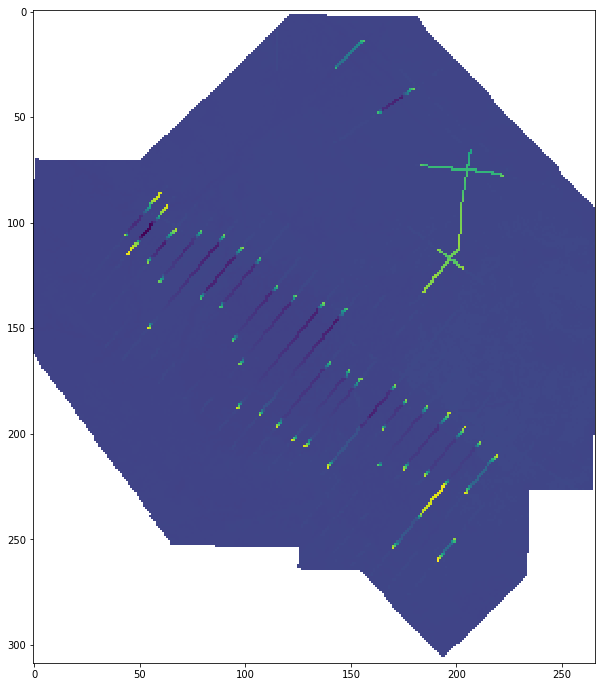

In [182]:
# build a list of columns/feautres to use for the classification process
train_features = [col for col in trainingdata.columns if col not in ([PVdepth] + ress)]
# subset the data to non-null rows
train_ss = trainingdata[trainingdata['depth_to_basement'].notnull()].dropna(axis = 0, how = 'any', subset = train_features)
train_x = train_ss[train_features].values
train_y = train_ss['depth_to_basement'].values

scaler = preprocessing.StandardScaler().fit(train_x)
train_x = scaler.transform(train_x)
train_x = preprocessing.normalize(train_x)

clf = SVR()
clf.fit(train_x,train_y)


predict_ss = trainingdata[trainingdata['depth_to_basement'].isnull()].dropna(axis = 0, how = 'any', subset = train_features)[train_features]
predict_ss_vals = predict_ss.values

# scale and normalize the data so it resembles the training data.
predict_ss_vals = scaler.transform(predict_ss_vals)
predict_ss_vals = preprocessing.normalize(predict_ss_vals)

# results of predict() are a 1 dimensional numpy array of the same length as the input data
# assign these results to a new column in the dataframe
predict_ss['PV_predicted'] = clf.predict(predict_ss_vals)

PV = predict_ss[['x','y','PV_predicted']].append(train_ss[['x','y','depth_to_basement']])
PV.loc[PV['depth_to_basement'].isna().index,'depth_to_basement'] = PV[PV['depth_to_basement'].isna()]['PV_predicted']
PV = PV.drop(labels = 'PV_predicted', axis = 1)
PV

PV = PV.combine_first(trainingdata[['depth_to_basement','x','y']])
PV = pd.merge(trainingdata['x','y'], PV, how='outer', left_index = True, right_index = True)
results = PV['depth_to_basement'].values.reshape(len(yrange), len(xrange))
results

plt.figure(figsize=[12,12])
imshow(np.flipud(results))

In [192]:
PV = pd.merge(trainingdata[['x','y']], PV, how='outer', left_index = True, right_index = True)
PV

,x_x,y_x,depth_to_basement,x_y,y_y
0,98567.0,-2486883.0,NaN,NaN,NaN
1,99067.0,-2486883.0,NaN,NaN,NaN
2,99567.0,-2486883.0,NaN,NaN,NaN
3,100067.0,-2486883.0,NaN,NaN,NaN
4,100567.0,-2486883.0,NaN,NaN,NaN
5,101067.0,-2486883.0,NaN,NaN,NaN
6,101567.0,-2486883.0,NaN,NaN,NaN
7,102067.0,-2486883.0,NaN,NaN,NaN
8,102567.0,-2486883.0,NaN,NaN,NaN
9,103067.0,-2486883.0,NaN,NaN,NaN


In [197]:
pv_x= PV[['x_x']].combine_first(PV[['x_y']])
# PV['y'] = PV[['y_x']].combine_first(PV[['y_y']])
# PV = PV[['x','y','depth_to_basement']]
pv_x

,x_x,x_y
0,98567.0,NaN
1,99067.0,NaN
2,99567.0,NaN
3,100067.0,NaN
4,100567.0,NaN
5,101067.0,NaN
6,101567.0,NaN
7,102067.0,NaN
8,102567.0,NaN
9,103067.0,NaN
